In [240]:

import pandas as pd
import numpy as np
import os
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=18)
plt.rc('text', usetex=True)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib
import pandas as pd
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import copy as cp
from typing import Tuple
from sklearn.metrics import confusion_matrix
import json
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline   
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import chi2
import os
import auxiliary as aux_func
from pathlib import Path
import math
import pickle
import lightgbm as lgb
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
MODEL_TYPE='weak'
# MODEL_TYPE='ct3d'
# MODEL_TYPE='ct2d'
# MODEL_TYPE='spm12'
# MODEL_TYPE='spm12contour'
CAL_TYPE = 'slice'
# CAL_TYPE = 'head'
import glob
import shap
FOLDS=5

import re
plt.style.use('classic')
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "stixsans"
plt.rc('figure',facecolor='w')
plt.rc('savefig',dpi=200)


def plot_confusion_matrix(actual_classes : np.array, predicted_classes : np.array, sorted_labels : list):

    matrix = confusion_matrix(actual_classes, predicted_classes, labels=sorted_labels)
    
    plt.figure(figsize=(12.8,6))
    sns.heatmap(matrix, annot=True, xticklabels=sorted_labels, yticklabels=sorted_labels, cmap="Blues", fmt="g")
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')

    plt.show()



# Per slice

In [241]:
SEARCH_PATH = '../../data4-4tb/kgreathoo/dataset_norm_mask_by_revisited'
nph_files = glob.glob(SEARCH_PATH + '/normal/*/s/*', recursive=True)
NPH = []
for i in nph_files:
    NPH.append(i.split('/')[-1])

In [242]:
# SEARCH_PATH = '../../data4-4tb/kgreathoo/dataset_norm_mask_by_revisited'
nph_files = glob.glob('/data2-2tb/kgreathoo/saved_img/nii_2023_focalloss_200epochs_lr_init=0.001_unet_scaled_224_allSlice_byTime_fold0ver_2023_maskv2/**.nii', recursive=True)
csf_spm_file = []
for i in nph_files:
    csf_spm_file.append(i.split('/')[-1])
    os.rename(i, i.replace('test',''))

### Data exploration

In [243]:
if MODEL_TYPE == 'weak':
    file1 = '/media/akara_bkp/nph_kgreat/kgreathoo/csv/perslice_all_10_code_aj_all_whole.csv'
    file2 = '/media/akara_bkp/nph_kgreat/kgreathoo/csv/perslice_all_10_codeWeak_fixV2.csv'

elif MODEL_TYPE == 'ct3d':
    file1 = '/media/akara_bkp/nph_kgreat/kgreathoo/csv/perslice_all_10_unet3d_fix_per.csv'
    file2 = '/media/akara_bkp/nph_kgreat/kgreathoo/csv/perslice_all_10_unet3d_global.csv'

elif MODEL_TYPE == 'ct2d':
    file1 = '/media/akara_bkp/nph_kgreat/kgreathoo/csv/perslice_all_10_unet2d_fix_per.csv'
    file2 = '/media/akara_bkp/nph_kgreat/kgreathoo/csv/perslice_all_10_unet2d_global.csv'

elif MODEL_TYPE == 'spm12':
    file1 = '/media/akara_bkp/nph_kgreat/kgreathoo/csv/perslice_all_10_spm12_fix_per.csv'
    file2 = '/media/akara_bkp/nph_kgreat/kgreathoo/csv/perslice_all_10_spm12_fix.csv'

elif MODEL_TYPE == 'spm12contour':
    file1 = '/media/akara_bkp/nph_kgreat/kgreathoo/csv/perslice_all_10_spm12contour_fix_per.csv'
    file2 = '/media/akara_bkp/nph_kgreat/kgreathoo/csv/perslice_all_10_spm12contour_fix.csv'

else:
    # Handle an unknown MODEL_TYPE
    raise ValueError(f'Unknown MODEL_TYPE: {MODEL_TYPE}')

#exclude0

# file1 = './csv/perslice_all_10_code_aj_all_whole.csv'
# file2 = './csv/perslice_all_10_codeWeak_exclude0.csv'


# file1 = './csv/perslice_all_10_ct3d.csv'
# file2 = './csv/perslice_all_10_unet3d_exclude0.csv'


# file1 = './csv/perslice_all_10_ct2d.csv'
# file2 = './csv/perslice_all_10_unet2d_exclude0.csv'


# file1 = './csv/perslice_all_10_spm12.csv'
# file2 = './csv/perslice_all_10_spm12_exclude0.csv'


# file1 = './csv/perslice_all_10_spm12contour.csv'
# file2 = './csv/perslice_all_10_spm12contour_exclude0.csv'


# Read CSV files into DataFrames
df1 = pd.read_csv(file1, header=0)
df2 = pd.read_csv(file2, header=0)

df1['y'] = np.where((df1['PatientID']).isin(NPH), 0, 1)
df2['y'] = np.where((df2['PatientID']).isin(NPH), 0, 1)

# Check the condition
if CAL_TYPE != 'head':
    # Extract columns from the first CSV file
    cols = []
    cols2 = []
    for i in range(10):
        cols.append(f'CSF ratio_{i}')
        cols.append(f'CSF / W+G matter ratio_{i}')
        cols.append(f"Mean CSF ratio_{i}")
        cols.append(f"Min CSF ratio_{i}")
        cols.append(f"Max CSF ratio_{i}")
        cols.append(f"Std CSF ratio_{i}")
        cols.append(f"Mean CSF / W+G matter ratio_{i}")
        cols.append(f"Min CSF / W+G matter ratio_{i}")
        cols.append(f"Max CSF / W+G matter ratio_{i}")
        cols.append(f"Std CSF / W+G matter ratio_{i}")

    # Extract additional columns from the first CSV file
    cols2.append('CSF ratio_all')
    cols2.append('CSF / W+G matter ratio_all')

    # Create new DataFrames with selected columns
    df2_selected = df2[cols2]
    df1[cols2] = df2_selected

data = df1
data['HN']=data['HN'].astype(str)

if CAL_TYPE!='head':
    new_data = data.fillna(0)
    data = new_data.groupby(['HN', 'fold'], sort=True).max(numeric_only=True).reset_index()

mismatch = pd.read_csv('p_pun_217.csv')
mismatch['HN'] = mismatch['HN'].astype(str)
merged_df = pd.merge(data[['HN', 'y']], mismatch[['HN', 'y']], on='HN', suffixes=('_data', '_mismatch'))
diff_df = merged_df[merged_df['y_data'] != merged_df['y_mismatch']]
hn_list = diff_df['HN'].tolist()
mask = data['HN'].isin(hn_list)
data.loc[mask, 'y'] = 0

In [244]:
if 'fix' not in file1 and 'fix' not in file2 and 'exclude' not in file1 and 'exclude' not in file2 and 'global' not in file1 and 'global' not in file2:
    print('old')
    data['CSF_ratio_sum_all'] = data[[f'CSF ratio_{i}' for i in range(10)]].sum(axis=1)/10
    data['CSF / W+G matter ratio_sum_all'] = data[[f'CSF / W+G matter ratio_{i}' for i in range(10)]].sum(axis=1)/10
else:
    data['CSF_ratio_all'] = data['CSF ratio_all']
    data['CSF_ratio_sum_all'] = data[[f'CSF ratio_{i}' for i in range(10)]].sum(axis=1)/10
    data['CSF / W+G matter ratio_sum_all'] = data[[f'CSF / W+G matter ratio_{i}' for i in range(10)]].sum(axis=1)/10


In [245]:
'''
reindex from 0-9 to 1-10

This code block reindexes the column names of the 'data' DataFrame. It replaces the numbers in the column names with incremented numbers, starting from 1. It also adds additional columns based on the original column names.
'''

data.columns = [
re.sub(r'(\w+) CSF ratio_(\d+)', lambda match: f'{match.group(1)} CSF ratio_{int(match.group(2)) + 1}', col)
for col in data.columns 
]
data.columns  = [
re.sub(r'^CSF ratio_(\d+)', lambda match: f'CSF ratio_{int(match.group(1)) + 1}', col)
for col in data.columns 
]

if CAL_TYPE!='head':
    cols=[]
    for i in range(1,11):
        cols.append(f'CSF ratio_{i}')     
        cols.append(f'CSF / W+G matter ratio_{i}')
        cols.append(f"Mean CSF ratio_{i}")
        cols.append(f"Min CSF ratio_{i}")
        cols.append(f"Max CSF ratio_{i}")
        cols.append(f"Std CSF ratio_{i}")
        cols.append(f"Mean CSF / W+G matter ratio_{i}")
        cols.append(f"Min CSF / W+G matter ratio_{i}")
        cols.append(f"Max CSF / W+G matter ratio_{i}")
        cols.append(f"Std CSF / W+G matter ratio_{i}")
    cols.append('CSF_ratio_all')
    cols.append('CSF / W+G matter ratio_all')
    cols.append('CSF_ratio_sum_all')
    cols.append('CSF / W+G matter ratio_sum_all')
        

### Implementing the model

In [246]:

train_test_folds = json.load(open('folds5_42_val.json'))

folds={}
num_fold=5
for fold_idx in range(num_fold):
    folds[fold_idx] = {
        'train':[i.split('/')[-1].split('-')[0].split('s')[1][0:10] for i in train_test_folds[str(fold_idx)]['train']],
        'test':[i.split('/')[-1].split('-')[0].split('s')[1][0:10]  for i in train_test_folds[str(fold_idx)]['test']],
        'val':[i.split('/')[-1].split('-')[0].split('s')[1][0:10]  for i in train_test_folds[str(fold_idx)]['val']],
    }
    fold_idx+=1

data['type'] = None

for fold_idx in range(num_fold):
    data.loc[(data['fold'] == int(fold_idx)) & data['HN'].isin(folds[fold_idx]['train']), 'type'] = f'train{fold_idx}'
    data.loc[(data['fold'] == int(fold_idx)) & data['HN'].isin(folds[fold_idx]['test']), 'type'] = f'test{fold_idx}'

data.drop_duplicates(subset=['HN','fold'], inplace=True)

In [247]:


"""
This code snippet defines a list of column names based on the value of the MODEL_TYPE variable that from previose features selection.
The column names are modified using regular expressions to increment the CSF ratio values by 1.
"""

if MODEL_TYPE == 'weak':
    cols = ['CSF ratio_5', 'Std CSF ratio_8', 'Mean CSF ratio_5',
            'Max CSF ratio_8', 'Max CSF ratio_6', 'Min CSF ratio_5',
            'Mean CSF ratio_8', 'Min CSF ratio_4', 'Max CSF ratio_7',
            'CSF ratio_4']

elif MODEL_TYPE == 'ct3d':
    cols =  ['CSF ratio_0',
     'Mean CSF ratio_0',
     'CSF / W+G matter ratio_0',
     'Max CSF ratio_0',
     'Mean CSF / W+G matter ratio_0',
     'CSF ratio_9',
     'Std CSF / W+G matter ratio_9',
     'Max CSF / W+G matter ratio_9',
     'Min CSF / W+G matter ratio_9',
     'Mean CSF / W+G matter ratio_9',
     'Std CSF ratio_9',
     'Max CSF ratio_9',
     'Min CSF ratio_9',
     'Mean CSF ratio_9',
     'CSF / W+G matter ratio_9',
     'Min CSF / W+G matter ratio_8',
     'Mean CSF ratio_5',
     'Std CSF / W+G matter ratio_8',
     'Mean CSF / W+G matter ratio_7',
     'Mean CSF / W+G matter ratio_8',
     'Std CSF ratio_8',
     'Max CSF ratio_8',
     'Min CSF ratio_8',
     'Mean CSF ratio_8',
     'CSF / W+G matter ratio_8',
     'CSF ratio_8',
     'Min CSF / W+G matter ratio_7',
     'Max CSF ratio_7',
     'Std CSF ratio_7',
     'Max CSF / W+G matter ratio_7',
     'Min CSF ratio_7',
     'Mean CSF ratio_7',
     'CSF / W+G matter ratio_7',
     'CSF ratio_7',
     'Std CSF / W+G matter ratio_6',
     'Max CSF / W+G matter ratio_6',
     'Min CSF / W+G matter ratio_6',
     'Mean CSF / W+G matter ratio_6',
     'Std CSF ratio_6',
     'Max CSF ratio_6',
     'Min CSF ratio_6',
     'Mean CSF ratio_6',
     'CSF / W+G matter ratio_6',
     'CSF ratio_6',
     'Std CSF / W+G matter ratio_5',
     'Max CSF / W+G matter ratio_5',
     'Min CSF / W+G matter ratio_5',
     'Mean CSF / W+G matter ratio_5',
     'Std CSF ratio_5',
     'Max CSF ratio_5',
     'Min CSF ratio_5',
     'Std CSF / W+G matter ratio_7',
     'Std CSF / W+G matter ratio_4',
     'Max CSF / W+G matter ratio_8',
     'CSF / W+G matter ratio_5',
     'Max CSF / W+G matter ratio_4',
     'Min CSF / W+G matter ratio_4',
     'Mean CSF / W+G matter ratio_4',
     'Std CSF ratio_4',
     'Max CSF ratio_4',
     'Min CSF ratio_4',
     'Mean CSF ratio_4',
     'Min CSF / W+G matter ratio_2',
     'CSF ratio_4',
     'Std CSF / W+G matter ratio_3',
     'CSF / W+G matter ratio_4',
     'Min CSF / W+G matter ratio_3',
     'Mean CSF / W+G matter ratio_3',
     'Std CSF ratio_3',
     'Max CSF ratio_3',
     'Min CSF ratio_3',
     'Mean CSF ratio_3',
     'CSF / W+G matter ratio_3',
     'CSF ratio_3',
     'Std CSF / W+G matter ratio_2',
     'Max CSF / W+G matter ratio_3',
     'Max CSF / W+G matter ratio_2',
     'Max CSF ratio_2',
     'Mean CSF / W+G matter ratio_2',
     'Std CSF ratio_2',
     'CSF_ratio_all',
     'Min CSF ratio_2',
     'Mean CSF ratio_2',
     'CSF / W+G matter ratio_2',
     'CSF ratio_2',
     'Std CSF / W+G matter ratio_1',
     'Max CSF / W+G matter ratio_1',
     'Min CSF / W+G matter ratio_1',
     'Mean CSF / W+G matter ratio_1',
     'Std CSF ratio_1',
     'Max CSF ratio_1',
     'Min CSF ratio_1',
     'Mean CSF ratio_1',
     'CSF / W+G matter ratio_1',
     'CSF ratio_1',
     'Std CSF / W+G matter ratio_0',
     'Max CSF / W+G matter ratio_0',
     'Min CSF / W+G matter ratio_0',
     'Std CSF ratio_0',
     'Min CSF ratio_0']

elif MODEL_TYPE == 'ct2d':
    cols = ['CSF / W+G matter ratio_all', 'CSF_ratio_all', 'Max CSF ratio_4',
       'CSF ratio_5', 'Mean CSF / W+G matter ratio_5', 'Max CSF ratio_5',
       'Mean CSF / W+G matter ratio_4', 'Max CSF / W+G matter ratio_5',
       'Min CSF ratio_4', 'Mean CSF ratio_6',
       'Min CSF / W+G matter ratio_4', 'Std CSF / W+G matter ratio_8',
       'Max CSF / W+G matter ratio_3', 'Min CSF ratio_6',
       'Min CSF / W+G matter ratio_6', 'Max CSF / W+G matter ratio_6',
       'CSF ratio_4', 'Std CSF ratio_8', 'Std CSF / W+G matter ratio_4',
       'Mean CSF / W+G matter ratio_6']

elif MODEL_TYPE == 'spm12':
    cols = ['Mean CSF ratio_5', 'Min CSF ratio_2', 'Mean CSF ratio_4',
       'Mean CSF / W+G matter ratio_5', 'Mean CSF ratio_7', 'CSF ratio_9',
       'Max CSF / W+G matter ratio_5', 'Min CSF / W+G matter ratio_5',
       'CSF ratio_2', 'CSF ratio_8', 'Min CSF / W+G matter ratio_4',
       'Mean CSF / W+G matter ratio_7', 'Max CSF ratio_7',
       'Max CSF ratio_5', 'CSF ratio_1', 'Max CSF ratio_3', 'CSF ratio_3',
       'CSF ratio_5', 'Max CSF ratio_8', 'CSF / W+G matter ratio_7',
       'Min CSF / W+G matter ratio_7', 'Max CSF / W+G matter ratio_4',
       'Min CSF ratio_5', 'CSF ratio_4', 'Min CSF / W+G matter ratio_2',
       'Max CSF ratio_4', 'CSF / W+G matter ratio_2',
       'CSF / W+G matter ratio_4', 'Max CSF / W+G matter ratio_8',
       'Std CSF ratio_1', 'CSF / W+G matter ratio_3',
       'Std CSF / W+G matter ratio_7', 'Mean CSF / W+G matter ratio_3',
       'Std CSF / W+G matter ratio_3', 'Mean CSF ratio_2', 'CSF ratio_7',
       'Std CSF / W+G matter ratio_6', 'Min CSF ratio_7',
       'Mean CSF / W+G matter ratio_4', 'Std CSF / W+G matter ratio_5',
       'Min CSF ratio_8', 'Std CSF ratio_3',
       'Min CSF / W+G matter ratio_6', 'Min CSF ratio_4',
       'Std CSF / W+G matter ratio_4', 'Max CSF / W+G matter ratio_3',
       'CSF_ratio_sum_all', 'CSF / W+G matter ratio_1', 'Min CSF ratio_3',
       'Std CSF ratio_8', 'Std CSF ratio_4',
       'Min CSF / W+G matter ratio_1', 'Min CSF / W+G matter ratio_8',
       'Std CSF ratio_7', 'Max CSF / W+G matter ratio_1',
       'CSF / W+G matter ratio_5', 'Mean CSF ratio_6', 'Std CSF ratio_2',
       'CSF / W+G matter ratio_6', 'CSF / W+G matter ratio_sum_all',
       'CSF_ratio_all', 'Min CSF ratio_6', 'Std CSF ratio_6',
       'Mean CSF / W+G matter ratio_2', 'Max CSF ratio_2',
       'Max CSF / W+G matter ratio_2', 'Mean CSF ratio_3',
       'Std CSF / W+G matter ratio_1', 'Mean CSF / W+G matter ratio_6',
       'Min CSF / W+G matter ratio_3', 'Max CSF / W+G matter ratio_7',
       'Mean CSF / W+G matter ratio_1', 'Std CSF ratio_5',
       'Max CSF / W+G matter ratio_6', 'Max CSF ratio_6',
       'CSF / W+G matter ratio_8', 'Max CSF ratio_1',
       'Std CSF / W+G matter ratio_8', 'Min CSF ratio_1',
       'Mean CSF / W+G matter ratio_8', 'Mean CSF ratio_1',
       'Mean CSF ratio_8', 'Std CSF / W+G matter ratio_2', 'CSF ratio_6',
       'CSF / W+G matter ratio_all', 'Std CSF ratio_9',
       'Max CSF / W+G matter ratio_9', 'Mean CSF ratio_9',
       'Max CSF ratio_9', 'Mean CSF / W+G matter ratio_9',
       'Std CSF / W+G matter ratio_9', 'Min CSF ratio_9',
       'Min CSF / W+G matter ratio_9', 'CSF / W+G matter ratio_9']

elif MODEL_TYPE == 'spm12contour':
    cols = ['Min CSF ratio_7', 'Std CSF ratio_3', 'Mean CSF ratio_8',
       'Std CSF / W+G matter ratio_3', 'Max CSF / W+G matter ratio_8',
       'Mean CSF / W+G matter ratio_4', 'CSF ratio_4',
       'Min CSF / W+G matter ratio_5', 'Min CSF ratio_4',
       'CSF / W+G matter ratio_7', 'CSF / W+G matter ratio_8',
       'Min CSF / W+G matter ratio_8', 'Max CSF ratio_8',
       'Mean CSF / W+G matter ratio_5', 'Std CSF ratio_1',
       'CSF_ratio_sum_all', 'Max CSF ratio_4',
       'Mean CSF / W+G matter ratio_8', 'Mean CSF ratio_5', 'CSF ratio_8',
       'Std CSF / W+G matter ratio_1', 'Min CSF / W+G matter ratio_4',
       'Max CSF / W+G matter ratio_6', 'Mean CSF ratio_2',
       'Mean CSF ratio_4', 'Min CSF ratio_5', 'CSF_ratio_all',
       'CSF / W+G matter ratio_2', 'CSF / W+G matter ratio_4',
       'Std CSF / W+G matter ratio_5', 'Min CSF ratio_2',
       'Min CSF / W+G matter ratio_7', 'Max CSF ratio_6',
       'Max CSF / W+G matter ratio_3', 'Mean CSF ratio_7', 'CSF ratio_5',
       'CSF ratio_1', 'Max CSF ratio_3', 'Max CSF / W+G matter ratio_5',
       'CSF ratio_2', 'Min CSF ratio_3', 'Min CSF / W+G matter ratio_2',
       'Std CSF ratio_8', 'Mean CSF ratio_3', 'Min CSF ratio_8',
       'CSF ratio_7', 'Std CSF ratio_5', 'CSF / W+G matter ratio_sum_all',
       'Max CSF ratio_1', 'Std CSF / W+G matter ratio_6',
       'Min CSF / W+G matter ratio_1', 'CSF ratio_3',
       'Min CSF / W+G matter ratio_3', 'Max CSF / W+G matter ratio_2',
       'Max CSF ratio_5', 'Std CSF / W+G matter ratio_8',
       'CSF / W+G matter ratio_3', 'Mean CSF / W+G matter ratio_1',
       'Max CSF / W+G matter ratio_4', 'CSF / W+G matter ratio_5',
       'Std CSF ratio_6', 'Std CSF ratio_7', 'Mean CSF ratio_6',
       'Min CSF ratio_1', 'Mean CSF / W+G matter ratio_7',
       'Std CSF / W+G matter ratio_4', 'Std CSF / W+G matter ratio_2',
       'Max CSF ratio_2', 'Max CSF ratio_7',
       'Mean CSF / W+G matter ratio_3', 'Max CSF / W+G matter ratio_7',
       'Max CSF / W+G matter ratio_1', 'CSF ratio_6',
       'CSF / W+G matter ratio_all', 'Std CSF ratio_4',
       'CSF / W+G matter ratio_6', 'Mean CSF / W+G matter ratio_9',
       'Mean CSF ratio_1', 'Mean CSF ratio_9',
       'Mean CSF / W+G matter ratio_2', 'Max CSF / W+G matter ratio_9',
       'Mean CSF / W+G matter ratio_6', 'Std CSF / W+G matter ratio_9',
       'Min CSF / W+G matter ratio_6', 'Min CSF ratio_6',
       'Std CSF ratio_9', 'CSF / W+G matter ratio_1', 'Std CSF ratio_2',
       'Max CSF ratio_9', 'CSF ratio_9', 'Std CSF / W+G matter ratio_7',
       'CSF / W+G matter ratio_9', 'Min CSF / W+G matter ratio_9',
       'Min CSF ratio_9']

else:
    # Handle an unknown MODEL_TYPE
    raise ValueError(f'Unknown MODEL_TYPE: {MODEL_TYPE}')
    
# cols = [
# re.sub(r'(\w+) CSF ratio_(\d+)', lambda match: f'{match.group(1)} CSF ratio_{int(match.group(2)) + 1}', col)
# for col in cols
# ]
# cols = [
# re.sub(r'^CSF ratio_(\d+)', lambda match: f'CSF ratio_{int(match.group(1)) + 1}', col)
# for col in cols
# ]


In [248]:
data

,HN,fold,Unnamed: 0,Mean CSF ratio_1,Max CSF ratio_1,Min CSF ratio_1,Std CSF ratio_1,CSF ratio_1,Mean CSF / W+G matter ratio_0,Max CSF / W+G matter ratio_0,...,Mean CSF / W+G matter ratio_9,Max CSF / W+G matter ratio_9,Min CSF / W+G matter ratio_9,Std CSF / W+G matter ratio_9,CSF / W+G matter ratio_9,CSF / W+G matter ratio_all,CSF_ratio_all,CSF_ratio_sum_all,CSF / W+G matter ratio_sum_all,type
0,38000954,0,3569,0.785287,1.000000,0.000000,0.393603,0.966038,5.720000,32.000000,...,0.004762,0.066667,0.0,0.017169,0.066667,0.146141,0.127507,0.230430,3.014427,train0
1,38000954,1,8059,0.466667,1.000000,0.000000,0.498888,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.169323,0.144804,0.236809,0.170946,train1
2,38000954,2,12549,0.482025,1.000000,0.000000,0.358960,0.429293,5.416183,54.000000,...,0.006494,0.090909,0.0,0.023413,0.090909,0.160098,0.138004,0.177903,0.243370,train2
3,38000954,3,17039,0.287351,0.407407,0.170648,0.062115,0.272147,0.414349,0.687500,...,0.000000,0.000000,0.0,0.000000,0.000000,0.112080,0.100784,0.119239,0.147265,train3
4,38000954,4,21529,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.042857,0.600000,0.0,0.154524,0.600000,0.204928,0.170075,0.203488,0.294330,train4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,54380859,0,1669,0.377607,1.000000,0.111388,0.292253,0.204632,0.749596,3.468750,...,0.027847,0.196546,0.0,0.061902,0.133806,0.091256,0.083625,0.123650,0.149407,train0
2236,54380859,1,6159,0.295226,0.730159,0.089655,0.220740,0.164431,0.656457,2.705882,...,0.011653,0.090837,0.0,0.027224,0.065197,0.093985,0.085911,0.113944,0.133829,test1
2237,54380859,2,10649,0.332342,0.752336,0.122253,0.204106,0.230769,0.756493,3.037736,...,0.031966,0.243270,0.0,0.073658,0.159512,0.100295,0.091153,0.136904,0.172722,train2
2238,54380859,3,15139,0.188345,0.382199,0.104600,0.084409,0.152266,0.247305,0.618644,...,0.004938,0.050076,0.0,0.014325,0.027462,0.071323,0.066574,0.078877,0.088447,train3


In [249]:
abnormal_cases_info = pd.read_csv('../abnormal_cases_info.csv')

In [250]:
FOLDS=5
# model='lr'
# model='RF'
model='light'
# model='load'
y_true = []
y_pred = []
y_prob = []
X=data[cols].to_numpy()
y=data['y']
Y=y.astype('int')
score_train=[]
score_test=[]
xx, yy = np.mgrid[-1:1.1:.01, -1:1.1:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
save_idx=[]
pred_df = pd.DataFrame()
for fold_idx in range(FOLDS):
    pred_df_tmp = pd.DataFrame()
    if '42' in file1 or 'code' in file1 :
        print('codeeee : ')
        data['type'] = None
        data['type'] = np.where((data['fold'] == int(fold_idx)) & data['HN'].isin(folds[fold_idx]['train']), f'train{fold_idx}', data['type'])
        data['type'] = np.where((data['fold'] == int(fold_idx)) & data['HN'].isin(folds[fold_idx]['test']), f'test{fold_idx}', data['type'])

    else:
        data['type']=None
        data['type'] = np.where(data['HN'].isin(folds[fold_idx]['train']), f'train{fold_idx}', data['type'])
        data['type'] = np.where(data['HN'].isin(folds[fold_idx]['test']), f'test{fold_idx}',data['type'])
        data['type'] = np.where(data['HN'].isin(folds[fold_idx]['val']), f'val{fold_idx}', data['type'])
        
        data['type'] = data.apply(lambda row: None if (row['type'] == f'test{fold_idx}' and row['HN'] in folds[fold_idx]['train']) else row['type'], axis=1)

    X_train = data[(data['type']==f'train{fold_idx}') | (data['type']==f'val{fold_idx}')][cols].to_numpy()
    y_train = data[(data['type']==f'train{fold_idx}') | (data['type']==f'val{fold_idx}')]['y'].to_numpy()
    X_test = data[data['type']==f'test{fold_idx}'][cols].to_numpy()
    y_test = data[data['type']==f'test{fold_idx}']['y'].to_numpy()
    test = train_test_folds['{}'.format(fold_idx)]['test']
    save_idx.append(data.index[data['type']==f'test{fold_idx}'].tolist())
    pred_df_tmp['HN'] =data[data['type']==f'test{fold_idx}']['HN']
    pred_df_tmp['y']=data[data['type']==f'test{fold_idx}']['y']


    if(model=='lr'):
        C=100
        model2 = LogisticRegression(class_weight="balanced", C=C,solver='lbfgs' ,max_iter=10000)
        model2 = LogisticRegression(C=C).fit(X_train, y_train)
    elif(model=='RF'):
        model2 = RandomForestClassifier(class_weight="balanced",n_estimators=5)
        model2.fit(X_train, y_train)
    elif(model=='light'):
#         num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, 
        model2 = lgb.LGBMClassifier(force_col_wise=True,class_weight="balanced",num_leaves=2, max_depth=0)
        model2.fit(X_train, y_train)
    else:
        model2 = pickle.load(open(f'/data2-2tb/kgreathoo/Weakconfident1{fold_idx}_89_2025.sav', 'rb'))
    print("%3d\t%.5f\t\t%.5f" % 
          (fold_idx, model2.score(X_train, y_train), model2.score(X_test, y_test)))

#     features_name = data[cols]
    

#     features_name.columns = [re.sub(r'^CSF ratio_(\d+)', r'$\omega^{(\1)}$', col) for col in features_name.columns]
#     features_name.columns = [re.sub(r'(\w+) CSF ratio_(\d+)', r'\1 $(\omega)^{(\2)}$', col) for col in features_name.columns]
#     features_name.columns = [re.sub(r'Std' , r'Std.', col) for col in features_name.columns]

#     if fold_idx==0:
#         explainer = shap.TreeExplainer(model2, X_train, feature_perturbation="interventional")
#         shap_values = explainer(features_name)
#         fig = plt.figure(figsize=(30, 28), dpi=300)
#         fig = shap.plots.beeswarm(shap_values, max_display=10, show=False)
# #         plt.title(title_map[MODEL_TYPE], fontsize=18, fontweight='bold')
# #         plt.savefig(f'SHAP10Weak.pdf', bbox_inches='tight')
#         plt.show()
    score_train.append(model2.score(X_train, y_train))
    score_test.append(model2.score(X_test, y_test))
    
    y_true.extend(y_test)
    y_pred.extend(model2.predict(X_test))
    y_prob.extend(model2.predict_proba(X_test))
#     pickle.dump(model2, open(f'Weakconfident1{fold_idx}_89_2025.sav', 'wb'))
#     pickle.dump(model2, open(f'SPM12confident1contour{fold_idx}.sav', 'wb'))
#     pickle.dump(model2, open(f'SPM12confident1{fold_idx}.sav', 'wb'))
#     pickle.dump(model2, open(f'headCT2023v2{fold_idx}.sav', 'wb'))
#     pickle.dump(model2, open(f'ct3d{fold_idx}.sav', 'wb'))

    pred_df = pd.concat([pred_df, pred_df_tmp], ignore_index=True)
pred_df['y_pred_model']=y_pred
pred_df['y_prob']=y_prob


# if(model=='lr'):
#     explainer = shap.LinearExplainer(model2, X_train, feature_perturbation="interventional")
#     shap_values = explainer(data[cols])
#     shap.plots.beeswarm(shap_values, max_display=200)
# elif(model=='RF'):
#     explainer = shap.TreeExplainer(model2)
#     shap_values = explainer(X_test)
#     shap_values = explainer.shap_values(data[cols]) 
#     shap.summary_plot(shap_values[1], data[cols]) 
# elif(model=='light'):
#     explainer = shap.TreeExplainer(model2, X_train, feature_perturbation="interventional")
#     shap_values = explainer(data[cols])
#     shap.plots.beeswarm(shap_values, max_display=200)

print(file1,'Accuracy: %.3f (%.3f)' % (mean(score_test), std(score_test)))
y_true = np.asarray(y_true)
y_pred = np.asarray(y_pred)
y_prob = np.asarray(y_prob)
print
confusion_matrix(y_true, y_pred, labels=[0, 1])
logit_roc_auc = roc_auc_score(y_true, y_prob[:, 1])
fpr, tpr, thresholds = roc_curve(y_true, y_prob[:,1])
print(classification_report(y_true, y_pred), f' (area = %0.2f)' % logit_roc_auc)
from sklearn.metrics import cohen_kappa_score
cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
TP, FN = cm[0]
FP, TN = cm[1]

accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
f1_score = (2 * TP) / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0
roc_auc = roc_auc_score(y_true, y_prob[:, 1])
cohen_kappa = cohen_kappa_score(y_true, y_pred)

# print("Acc\tSensiy\tSpec\tF1-Score\tTP\tTN\tFP\tFN\tAU-ROC\tCohen")
print(f"{accuracy:.3f}\t{sensitivity:.3f}\t{specificity:.3f}\t{f1_score:.3f}\t"
      f"{TP}\t{TN}\t{FP}\t{FN}\t{roc_auc:.3f}\t{cohen_kappa:.3f}")





codeeee : 
[LightGBM] [Info] Number of positive: 257, number of negative: 63
[LightGBM] [Info] Total Bins 1069
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
  0	0.77812		0.88636
codeeee : 
[LightGBM] [Info] Number of positive: 254, number of negative: 66
[LightGBM] [Info] Total Bins 1069
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
  1	0.81875		0.75000
codeeee : 
[LightGBM] [Info] Number of positive: 257, number of negative: 63
[LightGBM] [Info] Total Bins 1069
[LightGBM] [Info] Number of data points in the train set: 320, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[Lig

#Model classification

codeeee : 


Trying to unpickle estimator LabelEncoder from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations


  0	0.82188		0.54545
['CSF ratio_5', 'Std CSF ratio_8', 'Mean CSF ratio_5', 'Max CSF ratio_8', 'Max CSF ratio_6', 'Min CSF ratio_5', 'Mean CSF ratio_8', 'Min CSF ratio_4', 'Max CSF ratio_7', 'CSF ratio_4']
['CSF ratio_5', 'Std CSF ratio_8', 'Mean CSF ratio_5', 'Max CSF ratio_8', 'Max CSF ratio_6', 'Min CSF ratio_5', 'Mean CSF ratio_8', 'Min CSF ratio_4', 'Max CSF ratio_7', 'CSF ratio_4']


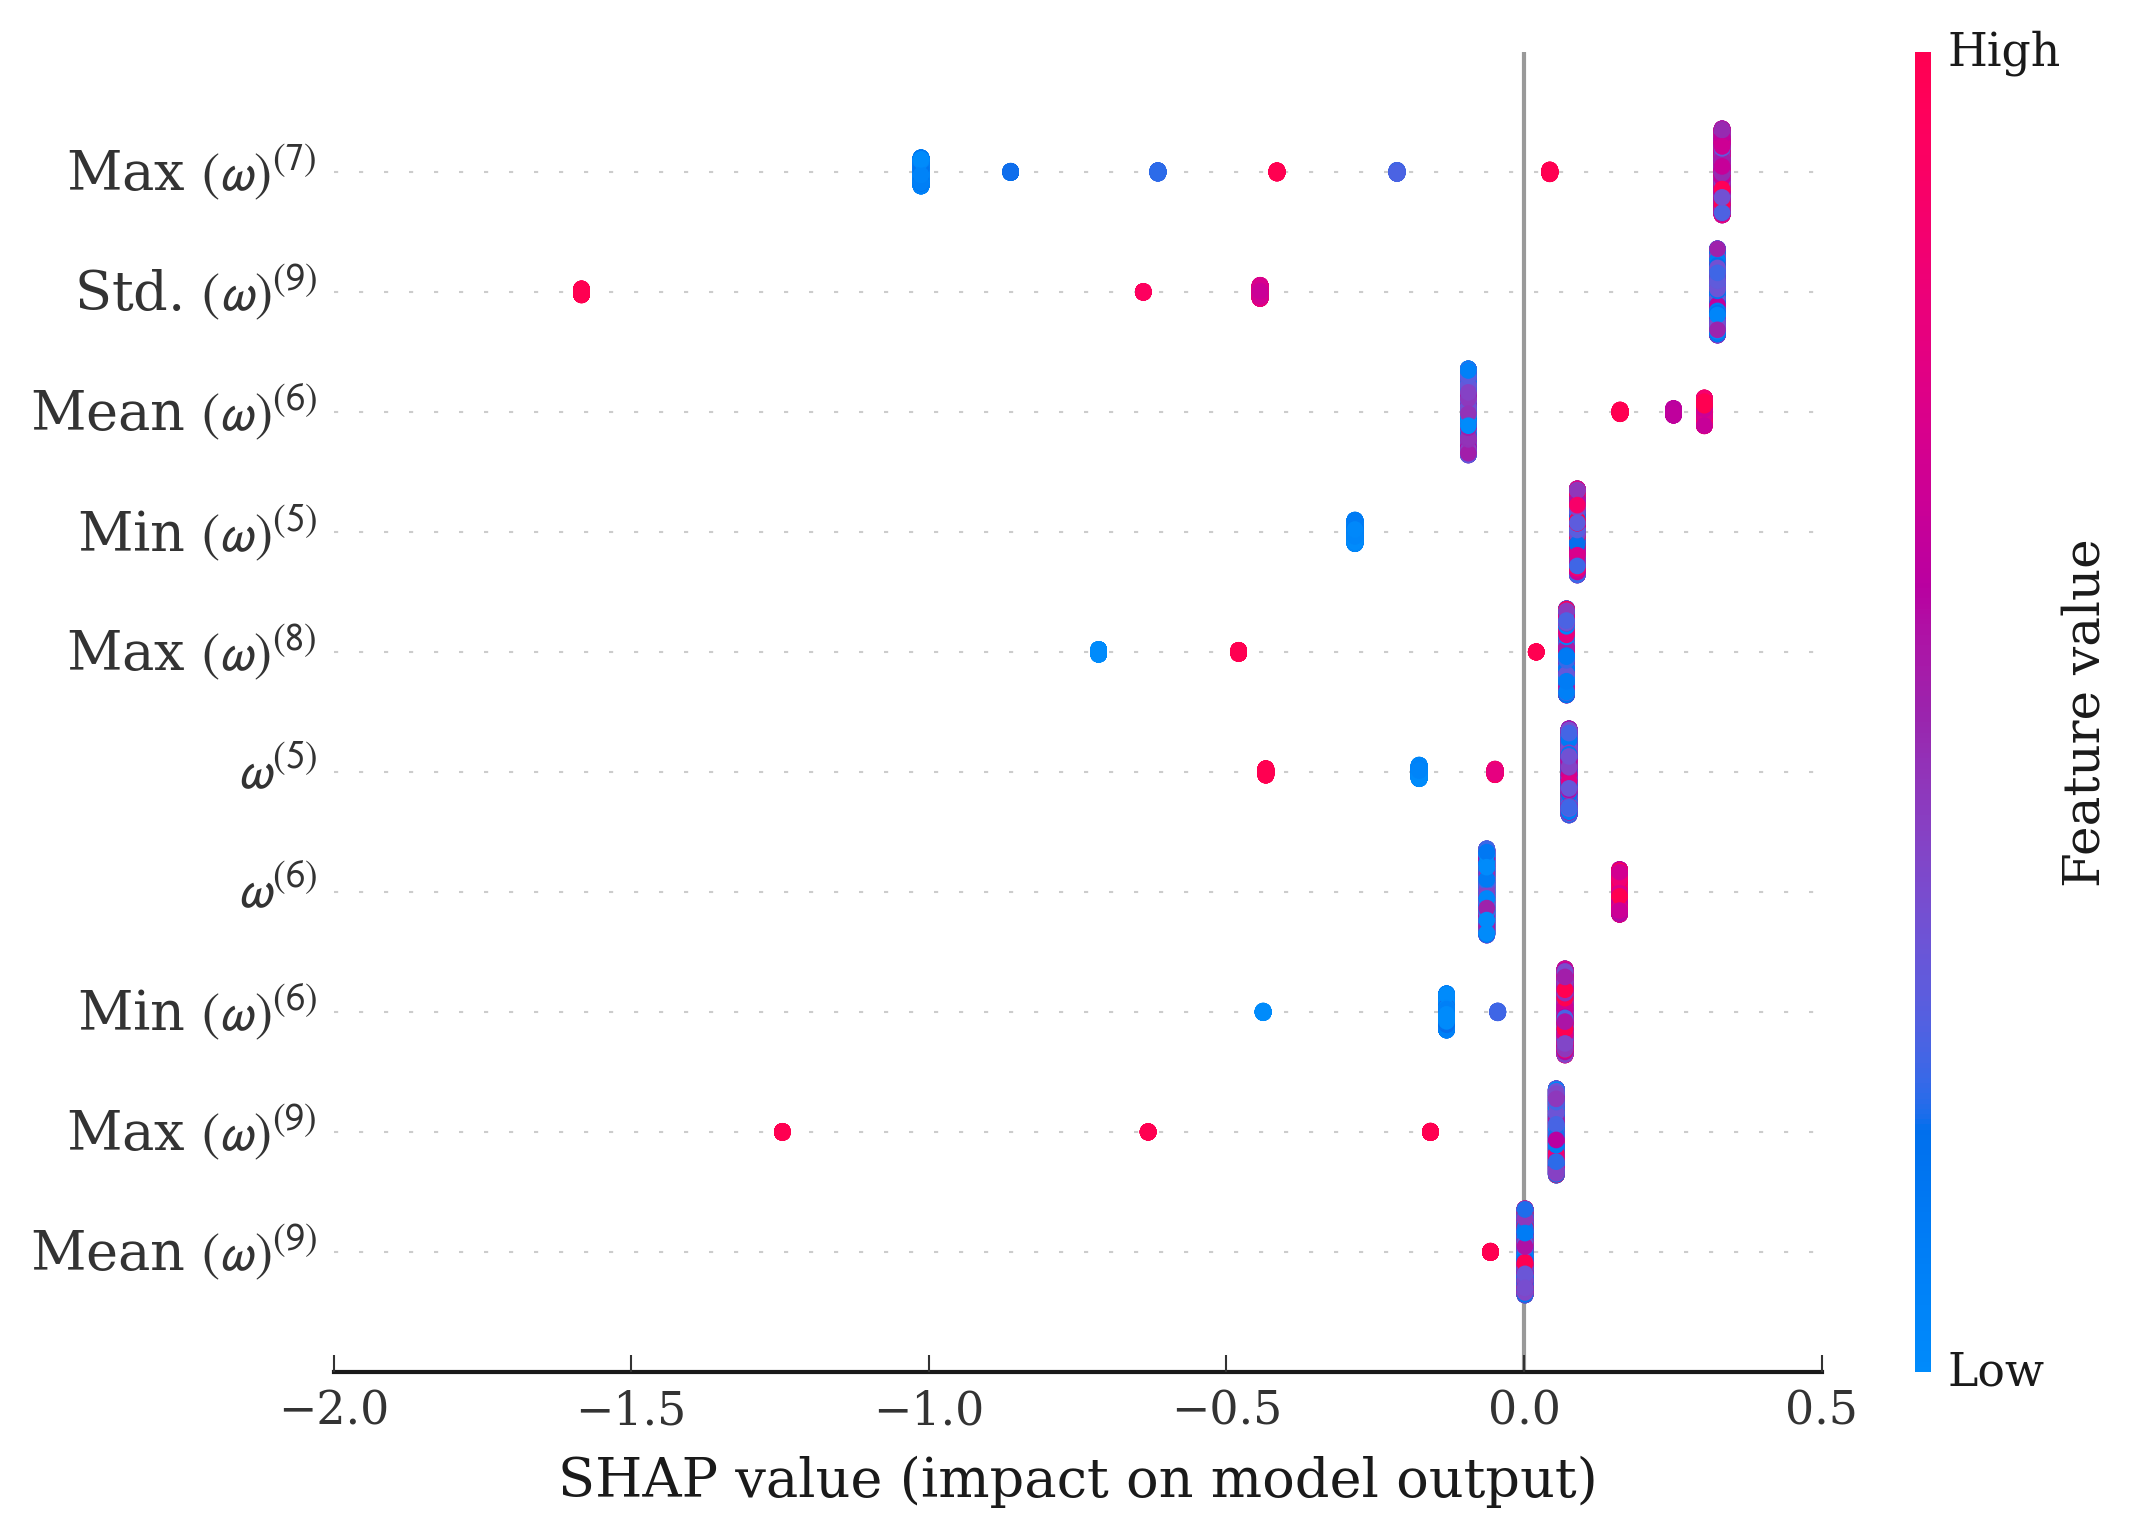

codeeee : 


Trying to unpickle estimator LabelEncoder from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations


  1	0.82188		0.65909
['CSF ratio_5', 'Std CSF ratio_8', 'Mean CSF ratio_5', 'Max CSF ratio_8', 'Max CSF ratio_6', 'Min CSF ratio_5', 'Mean CSF ratio_8', 'Min CSF ratio_4', 'Max CSF ratio_7', 'CSF ratio_4']
['CSF ratio_5', 'Std CSF ratio_8', 'Mean CSF ratio_5', 'Max CSF ratio_8', 'Max CSF ratio_6', 'Min CSF ratio_5', 'Mean CSF ratio_8', 'Min CSF ratio_4', 'Max CSF ratio_7', 'CSF ratio_4']
codeeee : 


Trying to unpickle estimator LabelEncoder from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations


  2	0.81250		0.44186
['CSF ratio_5', 'Std CSF ratio_8', 'Mean CSF ratio_5', 'Max CSF ratio_8', 'Max CSF ratio_6', 'Min CSF ratio_5', 'Mean CSF ratio_8', 'Min CSF ratio_4', 'Max CSF ratio_7', 'CSF ratio_4']
['CSF ratio_5', 'Std CSF ratio_8', 'Mean CSF ratio_5', 'Max CSF ratio_8', 'Max CSF ratio_6', 'Min CSF ratio_5', 'Mean CSF ratio_8', 'Min CSF ratio_4', 'Max CSF ratio_7', 'CSF ratio_4']
codeeee : 


Trying to unpickle estimator LabelEncoder from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations


  3	0.81875		0.76744
['CSF ratio_5', 'Std CSF ratio_8', 'Mean CSF ratio_5', 'Max CSF ratio_8', 'Max CSF ratio_6', 'Min CSF ratio_5', 'Mean CSF ratio_8', 'Min CSF ratio_4', 'Max CSF ratio_7', 'CSF ratio_4']
['CSF ratio_5', 'Std CSF ratio_8', 'Mean CSF ratio_5', 'Max CSF ratio_8', 'Max CSF ratio_6', 'Min CSF ratio_5', 'Mean CSF ratio_8', 'Min CSF ratio_4', 'Max CSF ratio_7', 'CSF ratio_4']
codeeee : 
  4	0.80312		0.69767
['CSF ratio_5', 'Std CSF ratio_8', 'Mean CSF ratio_5', 'Max CSF ratio_8', 'Max CSF ratio_6', 'Min CSF ratio_5', 'Mean CSF ratio_8', 'Min CSF ratio_4', 'Max CSF ratio_7', 'CSF ratio_4']
['CSF ratio_5', 'Std CSF ratio_8', 'Mean CSF ratio_5', 'Max CSF ratio_8', 'Max CSF ratio_6', 'Min CSF ratio_5', 'Mean CSF ratio_8', 'Min CSF ratio_4', 'Max CSF ratio_7', 'CSF ratio_4']
/media/akara_bkp/nph_kgreat/kgreathoo/csv/perslice_all_10_code_aj_all_whole.csv Accuracy: 0.622 (0.115)
[[ 31  81]
 [  1 104]]
              precision    recall  f1-score   support

           0       0.97  

Trying to unpickle estimator LabelEncoder from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations


In [227]:
# model='lr'
# model='RF'
# model='light'
model='load'
y_true = []
y_pred = []
y_prob = []
X=data[cols].to_numpy()
y=data['y']
Y=y.astype('int')
score_train=[]
score_test=[]
xx, yy = np.mgrid[-1:1.1:.01, -1:1.1:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
save_idx=[]
pred_df = pd.DataFrame()
for fold_idx in range(5):
    pred_df_tmp = pd.DataFrame()
    if '42' in file1 or 'code' in file1 :
        print('codeeee : ')
        data['type'] = None
        data['type'] = np.where((data['fold'] == int(fold_idx)) & data['HN'].isin(folds[fold_idx]['train']), f'train{fold_idx}', data['type'])
        data['type'] = np.where((data['fold'] == int(fold_idx)) & data['HN'].isin(folds[fold_idx]['test']), f'test{fold_idx}', data['type'])

    else:
        data['type']=None
        data['type'] = np.where(data['HN'].isin(folds[fold_idx]['train']), f'train{fold_idx}', data['type'])
        data['type'] = np.where(data['HN'].isin(folds[fold_idx]['test']), f'test{fold_idx}',data['type'])
        data['type'] = np.where(data['HN'].isin(folds[fold_idx]['val']), f'val{fold_idx}', data['type'])
        
        data['type'] = data.apply(lambda row: None if (row['type'] == f'test{fold_idx}' and row['HN'] in folds[fold_idx]['train']) else row['type'], axis=1)

    X_train = data[(data['type']==f'train{fold_idx}') | (data['type']==f'val{fold_idx}')][cols].to_numpy()
    y_train = data[(data['type']==f'train{fold_idx}') | (data['type']==f'val{fold_idx}')]['y'].to_numpy()
    X_test = data[data['type']==f'test{fold_idx}'][cols].to_numpy()
    y_test = data[data['type']==f'test{fold_idx}']['y'].to_numpy()
    test = train_test_folds['{}'.format(fold_idx)]['test']
    save_idx.append(data.index[data['type']==f'test{fold_idx}'].tolist())
    pred_df_tmp['HN'] =data[data['type']==f'test{fold_idx}']['HN']
    pred_df_tmp['y']=data[data['type']==f'test{fold_idx}']['y']


    if(model=='lr'):
        C=100
        model2 = LogisticRegression(class_weight="balanced", C=C,solver='lbfgs' ,max_iter=10000)
        model2 = LogisticRegression(C=C).fit(X_train, y_train)
    elif(model=='RF'):
        model2 = RandomForestClassifier(class_weight="balanced",n_estimators=5)
        model2.fit(X_train, y_train)
    elif(model=='light'):
#         num_leaves=31, max_depth=-1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, 
        model2 = lgb.LGBMClassifier(force_col_wise=True,class_weight="balanced",num_leaves=2, max_depth=1)
        model2.fit(X_train, y_train)
    else:
        model2 = pickle.load(open(f'/media/akara_bkp/nph_kgreat/nph-weak-sup/Weakconfident1{fold_idx}_89_2025.sav', 'rb'))
    print("%3d\t%.5f\t\t%.5f" % 
          (fold_idx, model2.score(X_train, y_train), model2.score(X_test, y_test)))


    features_name = data[cols]
    
# index เดิม
#     features_name.columns = [
#         re.sub(r'^CSF ratio_(\d+)', lambda m: rf'$\omega^{{({m.group(1)})}}$', col)
#         for col in features_name.columns
#     ]

#     features_name.columns = [
#         re.sub(r'(\w+) CSF ratio_(\d+)', lambda m: rf'{m.group(1)} $(\omega)^{{({m.group(2)})}}$', col)
#         for col in features_name.columns
#     ]

#     features_name.columns = [
#         re.sub(r'Std', 'Std.', col)
#         for col in features_name.columns
#     ]
# index +1
    features_name.columns = [
        re.sub(r'^CSF ratio_(\d+)', lambda m: rf'$\omega^{{({int(m.group(1)) + 1})}}$', col)
        for col in features_name.columns
    ]

    features_name.columns = [
        re.sub(r'(\w+) CSF ratio_(\d+)', lambda m: rf'{m.group(1)} $(\omega)^{{({int(m.group(2)) + 1})}}$', col)
        for col in features_name.columns
    ]

    features_name.columns = [
        re.sub(r'Std', 'Std.', col)
        for col in features_name.columns
    ]


    if fold_idx==0:
        explainer = shap.TreeExplainer(model2, X_train, feature_perturbation="interventional")
        shap_values = explainer(features_name)
        fig = plt.figure(figsize=(30, 28), dpi=300)
        fig = shap.plots.beeswarm(shap_values, max_display=10, show=False)
#         plt.title(title_map[MODEL_TYPE], fontsize=18, fontweight='bold')
#         plt.savefig(f'SHAP10Weak.pdf', bbox_inches='tight')
        plt.show()
    score_train.append(model2.score(X_train, y_train))
    score_test.append(model2.score(X_test, y_test))
    
    y_true.extend(y_test)
    y_pred.extend(model2.predict(X_test))
    y_prob.extend(model2.predict_proba(X_test))
#     pickle.dump(model2, open(f'Weakconfident1{fold_idx}_89.sav', 'wb'))
#     pickle.dump(model2, open(f'SPM12confident1contour{fold_idx}.sav', 'wb'))
#     pickle.dump(model2, open(f'SPM12confident1{fold_idx}.sav', 'wb'))
#     pickle.dump(model2, open(f'headCT2023v2{fold_idx}.sav', 'wb'))
#     pickle.dump(model2, open(f'ct3d{fold_idx}.sav', 'wb'))

    pred_df = pd.concat([pred_df, pred_df_tmp], ignore_index=True)
pred_df['y_pred_model']=y_pred


# if(model=='lr'):
#     explainer = shap.LinearExplainer(model2, X_train, feature_perturbation="interventional")
#     shap_values = explainer(data[cols])
#     shap.plots.beeswarm(shap_values, max_display=200)
# elif(model=='RF'):
#     explainer = shap.TreeExplainer(model2)
#     shap_values = explainer(X_test)
#     shap_values = explainer.shap_values(data[cols]) 
#     shap.summary_plot(shap_values[1], data[cols]) 
# elif(model=='light'):
#     explainer = shap.TreeExplainer(model2, X_train, feature_perturbation="interventional")
#     shap_values = explainer(data[cols])
#     shap.plots.beeswarm(shap_values, max_display=200)

print(file1,'Accuracy: %.3f (%.3f)' % (mean(score_test), std(score_test)))
y_true = np.asarray(y_true)
y_pred = np.asarray(y_pred)
y_prob = np.asarray(y_prob)
confusion_matrix(y_true, y_pred, labels=[0, 1])
logit_roc_auc = roc_auc_score(y_true, y_pred)
fpr, tpr, thresholds = roc_curve(y_true, y_prob[:,1])
cm = confusion_matrix(y_true, y_pred)
print(cm)
print(classification_report(y_true, y_pred), f' (area = %0.2f)' % logit_roc_auc)
from sklearn.metrics import cohen_kappa_score
print('cohen',cohen_kappa_score(y_true, y_pred))





In [55]:
abnormal_cases_info['HN']

0      38160661
1      54380859
2      54354537
3      54270102
4      54065132
         ...   
212    52762633
213    53189614
214    53798105
215    53882768
216    54203499
Name: HN, Length: 217, dtype: int64

In [54]:
data['HN']

0       38000954
1       38000954
2       38000954
3       38000954
4       38000954
          ...   
2235    54380859
2236    54380859
2237    54380859
2238    54380859
2239    54380859
Name: HN, Length: 2240, dtype: object

{(51131969, 4), (53915135, 1), (46003874, 1), (51209446, 4), (50151931, 3), (38900161, 0), (54278767, 1), (48168011, 2), (51256496, 2), (54104142, 0), (45064706, 4), (40151265, 4), (46010936, 1), (44096626, 2), (38160661, 3), (38182610, 4), (54273498, 1), (40026144, 4), (41128291, 0), (54231068, 1), (38136681, 4), (42004905, 4), (53833962, 1), (49252872, 3), (52589804, 0), (48104673, 1), (52602113, 4), (53650120, 2), (54065132, 3), (44130155, 1), (45084446, 0), (54071082, 2), (41009872, 0), (54066067, 0), (54164431, 0), (49161849, 2), (39108404, 4), (53872843, 4), (42052801, 1), (53701955, 3), (54022321, 1), (54279570, 0), (53885058, 1), (44119324, 4), (53338968, 2), (54232314, 0), (53111503, 1), (51269310, 0), (41051113, 2), (52923489, 1), (54206772, 0), (42204536, 2), (47121487, 3), (49243612, 3), (53076338, 2), (46025187, 2), (46023027, 3), (50167760, 3), (53994956, 1), (40018977, 3), (52531308, 4), (54209927, 1), (54354537, 0), (38089950, 3), (43140800, 2), (51176610, 4), (40142142

Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations


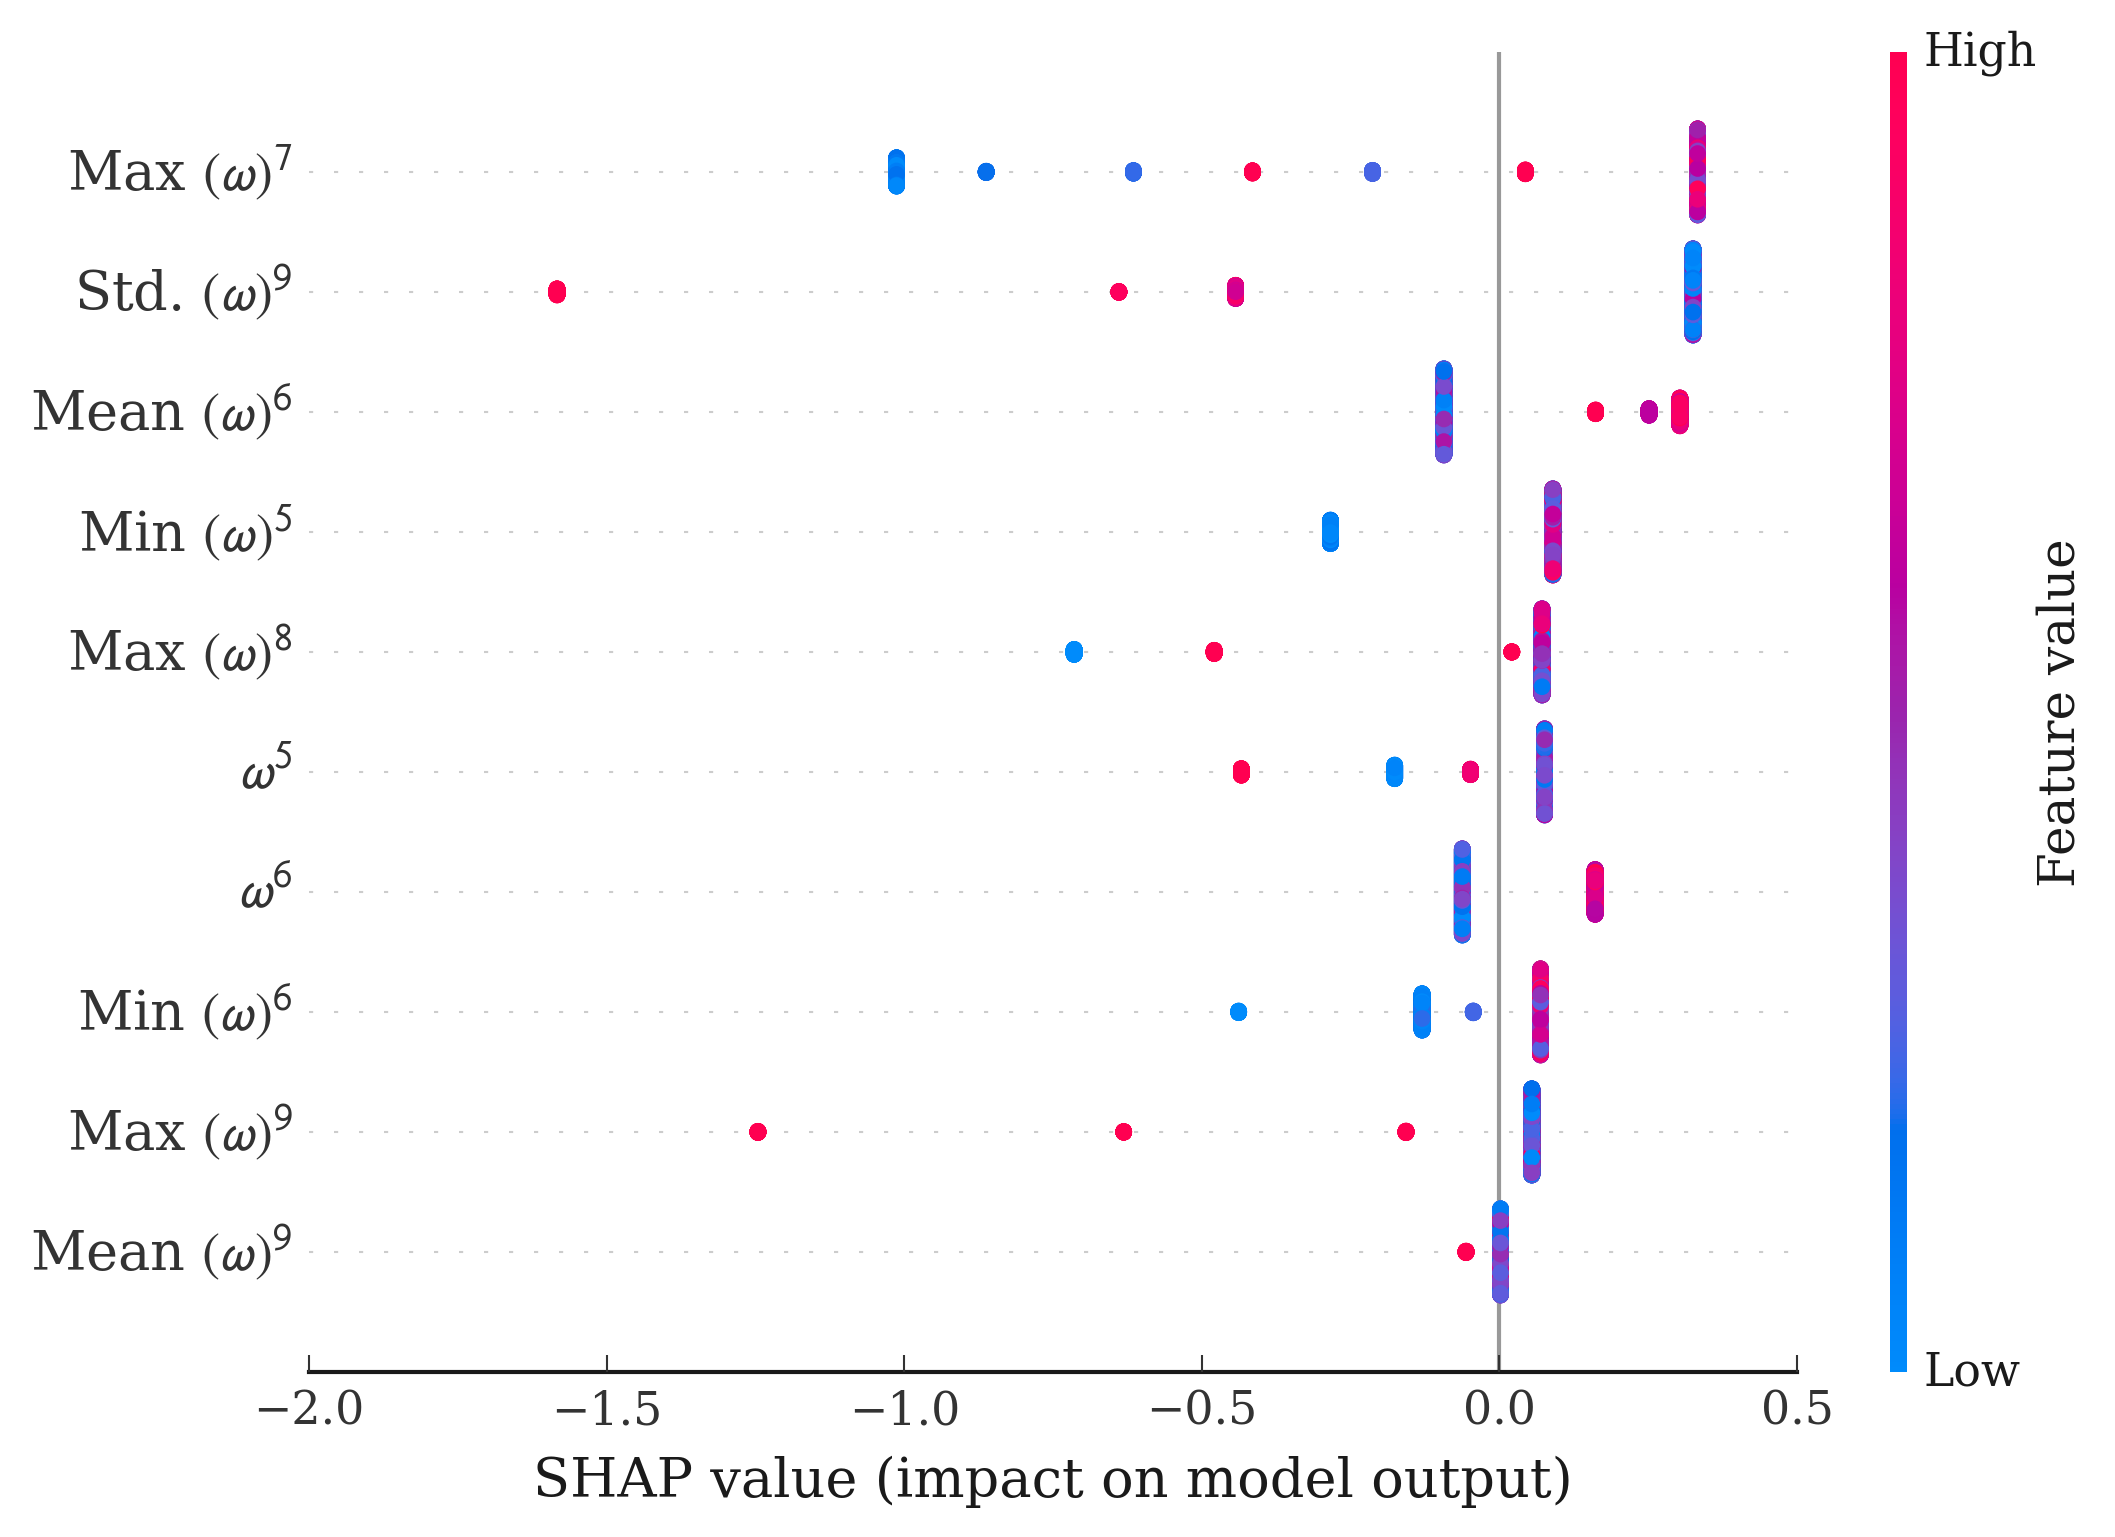

1	0.82188		0.65909
2	0.81250		0.41463
3	0.81875		0.76190
4	0.80312		0.69767
/data2-2tb/kgreathoo/csv/perslice_all_10_code_aj_all_whole.csv Accuracy: 0.616 (0.137)
[[ 31  81]
 [  1 101]]
              precision    recall  f1-score   support

           0       0.97      0.28      0.43       112
           1       0.55      0.99      0.71       102

    accuracy                           0.62       214
   macro avg       0.76      0.63      0.57       214
weighted avg       0.77      0.62      0.56       214
  (area = 0.63)
cohen 0.2579499323410013


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking co

In [58]:
import pandas as pd
import numpy as np
import pickle
import re
import shap
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    cohen_kappa_score
)
from statistics import mean, stdev as std

# Load abnormal HN + fold info
abnormal_cases_info['fold'] = abnormal_cases_info['type'].str.extract(r'test(\d+)').astype(int)
interested_test_keys = set(zip(abnormal_cases_info['HN'], abnormal_cases_info['fold']))

# Assume these are predefined
# data, cols, folds, train_test_folds, file1

model = 'load'
y_true = []
y_pred = []
y_prob = []
X = data[cols].to_numpy()
y = data['y']
score_train = []
score_test = []
save_idx = []
pred_df = pd.DataFrame()

for fold_idx in range(5):
    pred_df_tmp = pd.DataFrame()

    if '42' in file1 or 'code' in file1:
        data['type'] = None
        data['type'] = np.where(
            (data['fold'] == int(fold_idx)) & data['HN'].isin(folds[fold_idx]['train']),
            f'train{fold_idx}', data['type']
        )
        data['type'] = np.where(
            (data['fold'] == int(fold_idx)) & data['HN'].isin(folds[fold_idx]['test']),
            f'test{fold_idx}', data['type']
        )
    else:
        data['type'] = None
        data['type'] = np.where(data['HN'].isin(folds[fold_idx]['train']), f'train{fold_idx}', data['type'])
        data['type'] = np.where(data['HN'].isin(folds[fold_idx]['test']), f'test{fold_idx}', data['type'])
        data['type'] = np.where(data['HN'].isin(folds[fold_idx]['val']), f'val{fold_idx}', data['type'])
        data['type'] = data.apply(
            lambda row: None if (row['type'] == f'test{fold_idx}' and row['HN'] in folds[fold_idx]['train']) else row['type'],
            axis=1
        )

    # Train set
    X_train = data[(data['type'] == f'train{fold_idx}') | (data['type'] == f'val{fold_idx}')][cols].to_numpy()
    y_train = data[(data['type'] == f'train{fold_idx}') | (data['type'] == f'val{fold_idx}')]['y'].to_numpy()

    # Test set (filtered by interested HN+fold)
    data_filtered = data[
        data.apply(lambda row: (int(row['HN']), fold_idx) in interested_test_keys and row['type'] == f'test{fold_idx}', axis=1)
    ]
    X_test = data_filtered[cols].to_numpy()
    y_test = data_filtered['y'].to_numpy()
    pred_df_tmp['HN'] = data_filtered['HN']
    pred_df_tmp['y'] = data_filtered['y']

    # Load model
    if model == 'lr':
        model2 = LogisticRegression(C=100, max_iter=10000).fit(X_train, y_train)
    else:
        model2 = pickle.load(open(f'/data2-2tb/kgreathoo/Weakconfident1{fold_idx}_89.sav', 'rb'))

    print(f"{fold_idx}\t{model2.score(X_train, y_train):.5f}\t\t{model2.score(X_test, y_test):.5f}")

    # Rename for SHAP
    features_name = data[cols].copy()
    features_name.columns = [
        re.sub(r'^CSF ratio_(\d+)', lambda m: rf'$\omega^{{{int(m.group(1)) + 1}}}$', col)
        for col in features_name.columns
    ]
    features_name.columns = [
        re.sub(r'(\w+) CSF ratio_(\d+)', lambda m: rf'{m.group(1)} $(\omega)^{{{int(m.group(2)) + 1}}}$', col)
        for col in features_name.columns
    ]
    features_name.columns = [
        re.sub(r'Std', 'Std.', col)
        for col in features_name.columns
    ]

    if fold_idx == 0:
        explainer = shap.TreeExplainer(model2, X_train, feature_perturbation="interventional")
        shap_values = explainer(features_name)
        fig = plt.figure(figsize=(30, 28), dpi=300)
        shap.plots.beeswarm(shap_values, max_display=10, show=False)
        plt.show()

    # Score
    score_train.append(model2.score(X_train, y_train))
    score_test.append(model2.score(X_test, y_test))

    y_true.extend(y_test)
    y_pred.extend(model2.predict(X_test))
    y_prob.extend(model2.predict_proba(X_test))
    pred_df = pd.concat([pred_df, pred_df_tmp], ignore_index=True)

# Final evaluation
pred_df['y_pred_model'] = y_pred
print(file1, 'Accuracy: %.3f (%.3f)' % (mean(score_test), std(score_test)))

y_true = np.asarray(y_true)
y_pred = np.asarray(y_pred)
y_prob = np.asarray(y_prob)
cm = confusion_matrix(y_true, y_pred)
print(cm)
print(classification_report(y_true, y_pred), f' (area = %0.2f)' % roc_auc_score(y_true, y_pred))
print('cohen', cohen_kappa_score(y_true, y_pred))


In [57]:
pred_df['HN'] = pred_df['HN'].astype(str)

In [251]:
import pandas as pd
import shap
import pickle
import matplotlib.pyplot as plt

# โหลด interest case ที่สนใจ (เฉพาะ test fold)
abnormal_info = pd.read_csv("/data4-4tb/kgreathoo/abnormal_cases_info.csv")
abnormal_info['HN'] = abnormal_info['HN'].astype(int)
abnormal_info = abnormal_info[abnormal_info['type'].str.contains('test')]
abnormal_info['fold'] = abnormal_info['type'].str.extract(r'test(\d+)').astype(int)


In [124]:
import os
import pickle
import shap
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import glob

def find_partition_img(hn: int, plots_dir='/data4-4tb/kgreathoo/plots_result'):
    # ค้นหาไฟล์ที่มี HN อยู่ในชื่อ
    matching_files = glob.glob(os.path.join(plots_dir, f"*{hn}*.png"))
    print(matching_files)
    if matching_files:
        return matching_files[0],matching_files[0].split('/')[-1]  # เอาไฟล์แรกที่เจอ
    return None

def generate_pretty_title(filename):
    base = os.path.basename(filename)
    base = base.replace('_', ' ').replace('.png', '')
    # ลบ "peak idx" เป็น "Peak" และ "type" เป็น "Type"
    base = base.replace('peak idx', 'Peak Index')
    base = base.replace('type', 'Type')
    base = base.replace('HN', 'HN')
    # เติมความเป็นระเบียบ
    return base.title()

output_dir = "shap_outputs_1_10_new"
os.makedirs(output_dir, exist_ok=True)

for i, row in abnormal_info.iterrows():
    hn = row['HN']
    fold = int(row['fold'])
    peak = int(row['peak_partition'])+1
    type_name = row['type']

    # โหลดโมเดล
#     model_path = f'/data2-2tb/kgreathoo/Weakconfident1{fold}_89.sav'
    model_path = f'/media/akara_bkp/nph_kgreat/kgreathoo/Weakconfident1{fold}_89.sav'
    if not os.path.exists(model_path):
        print(f"❌ ไม่พบโมเดล: {model_path}")
        continue
    model = pickle.load(open(model_path, 'rb'))

    # เตรียมข้อมูล
    person_row = data[(data['HN'].astype(int) == hn) & (data['fold'] == fold)]
    if person_row.empty:
        print(f"❌ ไม่พบ HN={hn}, fold={fold}")
        continue
    X_sample = person_row[cols].values.reshape(1, -1)

    # คำนวณ SHAP
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sample)

    # บันทึก SHAP เป็นไฟล์เดี่ยว
    shap_img_path = os.path.join(output_dir, f'shap_HN{hn}_fold{fold}.png')
    plt.figure()
    
    def adjust_partition_index(name):
        return re.sub(r'_(\d+)', lambda m: f'_{int(m.group(1)) + 1}', name)

    adjusted_cols = [adjust_partition_index(col) for col in cols]
    shap.plots.waterfall(
        shap.Explanation(
            values=shap_values[1][0],
            base_values=explainer.expected_value[1],
            data=X_sample[0],
            feature_names=adjusted_cols
        ),
        show=False
    )
    plt.tight_layout()
    plt.savefig(shap_img_path, dpi=150, bbox_inches='tight')
    plt.close()

    # เตรียม path ของภาพ partition
    img_path, img_name = find_partition_img(hn)
    if img_path:
        title = generate_pretty_title(img_path)
        print(f"✅ Image: {img_path}")
        print(f"🖼️ Title: {title}")
    else:
        print(f"❌ ไม่พบภาพของ HN: {hn}")
    if not os.path.exists(img_path):
        print(f"❌ ไม่พบภาพ CT: {img_path}")
        continue

    # รวมภาพ SHAP + CT partition
    shap_img = Image.open(shap_img_path)
    partition_img = Image.open(img_path)

    # ปรับขนาดให้เท่ากันด้านสูง
    h = max(shap_img.height, partition_img.height)
#     print(h)
    partition_img = partition_img.resize((int(shap_img.width * h / shap_img.height), h))


    combined = Image.new("RGB", (shap_img.width + partition_img.width, h), color=(255, 255, 255))
    combined.paste(shap_img, (0, 0))
    combined.paste(partition_img, (shap_img.width, 0))

    final_path = os.path.join(output_dir, img_name)
    combined.save(final_path)
    print(f"✅ Saved combined image: {final_path}")

    # ลบภาพเดี่ยว (ถ้าไม่ต้องการเก็บไว้)
    os.remove(shap_img_path)
#     break


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/38160661_peak_idx_1_type_test3_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/38160661_peak_idx_1_type_test3_TP.png
🖼️ Title: 38160661 Peak Index 1 Type Test3 Tp
✅ Saved combined image: shap_outputs_1_10_new/38160661_peak_idx_1_type_test3_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/54380859_peak_idx_2_type_test1_FN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/54380859_peak_idx_2_type_test1_FN.png
🖼️ Title: 54380859 Peak Index 2 Type Test1 Fn
✅ Saved combined image: shap_outputs_1_10_new/54380859_peak_idx_2_type_test1_FN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/54354537_peak_idx_1_type_test0_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/54354537_peak_idx_1_type_test0_TP.png
🖼️ Title: 54354537 Peak Index 1 Type Test0 Tp
✅ Saved combined image: shap_outputs_1_10_new/54354537_peak_idx_1_type_test0_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/54270102_peak_idx_1_type_test1_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/54270102_peak_idx_1_type_test1_TP.png
🖼️ Title: 54270102 Peak Index 1 Type Test1 Tp
✅ Saved combined image: shap_outputs_1_10_new/54270102_peak_idx_1_type_test1_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/54065132_peak_idx_9_type_test3_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/54065132_peak_idx_9_type_test3_TP.png
🖼️ Title: 54065132 Peak Index 9 Type Test3 Tp
✅ Saved combined image: shap_outputs_1_10_new/54065132_peak_idx_9_type_test3_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/54025856_peak_idx_1_type_test1_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/54025856_peak_idx_1_type_test1_TP.png
🖼️ Title: 54025856 Peak Index 1 Type Test1 Tp
✅ Saved combined image: shap_outputs_1_10_new/54025856_peak_idx_1_type_test1_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/54015465_peak_idx_1_type_test0_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/54015465_peak_idx_1_type_test0_TP.png
🖼️ Title: 54015465 Peak Index 1 Type Test0 Tp
✅ Saved combined image: shap_outputs_1_10_new/54015465_peak_idx_1_type_test0_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/54010045_peak_idx_10_type_test4_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/54010045_peak_idx_10_type_test4_TP.png
🖼️ Title: 54010045 Peak Index 10 Type Test4 Tp
✅ Saved combined image: shap_outputs_1_10_new/54010045_peak_idx_10_type_test4_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/53994956_peak_idx_2_type_test1_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/53994956_peak_idx_2_type_test1_TP.png
🖼️ Title: 53994956 Peak Index 2 Type Test1 Tp
✅ Saved combined image: shap_outputs_1_10_new/53994956_peak_idx_2_type_test1_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/53966383_peak_idx_1_type_test4_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/53966383_peak_idx_1_type_test4_TP.png
🖼️ Title: 53966383 Peak Index 1 Type Test4 Tp
✅ Saved combined image: shap_outputs_1_10_new/53966383_peak_idx_1_type_test4_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/53885058_peak_idx_1_type_test1_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/53885058_peak_idx_1_type_test1_TP.png
🖼️ Title: 53885058 Peak Index 1 Type Test1 Tp
✅ Saved combined image: shap_outputs_1_10_new/53885058_peak_idx_1_type_test1_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/53833962_peak_idx_1_type_test1_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/53833962_peak_idx_1_type_test1_TP.png
🖼️ Title: 53833962 Peak Index 1 Type Test1 Tp
✅ Saved combined image: shap_outputs_1_10_new/53833962_peak_idx_1_type_test1_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/53827103_peak_idx_1_type_test1_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/53827103_peak_idx_1_type_test1_TP.png
🖼️ Title: 53827103 Peak Index 1 Type Test1 Tp
✅ Saved combined image: shap_outputs_1_10_new/53827103_peak_idx_1_type_test1_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/53790928_peak_idx_2_type_test0_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/53790928_peak_idx_2_type_test0_TP.png
🖼️ Title: 53790928 Peak Index 2 Type Test0 Tp
✅ Saved combined image: shap_outputs_1_10_new/53790928_peak_idx_2_type_test0_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/53714114_peak_idx_1_type_test3_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/53714114_peak_idx_1_type_test3_TP.png
🖼️ Title: 53714114 Peak Index 1 Type Test3 Tp
✅ Saved combined image: shap_outputs_1_10_new/53714114_peak_idx_1_type_test3_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/53701955_peak_idx_6_type_test3_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/53701955_peak_idx_6_type_test3_TP.png
🖼️ Title: 53701955 Peak Index 6 Type Test3 Tp
✅ Saved combined image: shap_outputs_1_10_new/53701955_peak_idx_6_type_test3_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/53601117_peak_idx_1_type_test0_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/53601117_peak_idx_1_type_test0_TP.png
🖼️ Title: 53601117 Peak Index 1 Type Test0 Tp
✅ Saved combined image: shap_outputs_1_10_new/53601117_peak_idx_1_type_test0_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/53574742_peak_idx_1_type_test0_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/53574742_peak_idx_1_type_test0_TP.png
🖼️ Title: 53574742 Peak Index 1 Type Test0 Tp
✅ Saved combined image: shap_outputs_1_10_new/53574742_peak_idx_1_type_test0_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/53427016_peak_idx_1_type_test3_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/53427016_peak_idx_1_type_test3_TP.png
🖼️ Title: 53427016 Peak Index 1 Type Test3 Tp
✅ Saved combined image: shap_outputs_1_10_new/53427016_peak_idx_1_type_test3_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/53411890_peak_idx_9_type_test2_FN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/53411890_peak_idx_9_type_test2_FN.png
🖼️ Title: 53411890 Peak Index 9 Type Test2 Fn
✅ Saved combined image: shap_outputs_1_10_new/53411890_peak_idx_9_type_test2_FN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/53111503_peak_idx_1_type_test1_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/53111503_peak_idx_1_type_test1_TP.png
🖼️ Title: 53111503 Peak Index 1 Type Test1 Tp
✅ Saved combined image: shap_outputs_1_10_new/53111503_peak_idx_1_type_test1_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/53005034_peak_idx_1_type_test0_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/53005034_peak_idx_1_type_test0_TP.png
🖼️ Title: 53005034 Peak Index 1 Type Test0 Tp
✅ Saved combined image: shap_outputs_1_10_new/53005034_peak_idx_1_type_test0_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/52871248_peak_idx_2_type_test1_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/52871248_peak_idx_2_type_test1_TP.png
🖼️ Title: 52871248 Peak Index 2 Type Test1 Tp
✅ Saved combined image: shap_outputs_1_10_new/52871248_peak_idx_2_type_test1_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/52610487_peak_idx_1_type_test3_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/52610487_peak_idx_1_type_test3_TP.png
🖼️ Title: 52610487 Peak Index 1 Type Test3 Tp
✅ Saved combined image: shap_outputs_1_10_new/52610487_peak_idx_1_type_test3_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/52602113_peak_idx_1_type_test4_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/52602113_peak_idx_1_type_test4_TP.png
🖼️ Title: 52602113 Peak Index 1 Type Test4 Tp
✅ Saved combined image: shap_outputs_1_10_new/52602113_peak_idx_1_type_test4_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/52589797_peak_idx_6_type_test1_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/52589797_peak_idx_6_type_test1_TP.png
🖼️ Title: 52589797 Peak Index 6 Type Test1 Tp
✅ Saved combined image: shap_outputs_1_10_new/52589797_peak_idx_6_type_test1_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/52540642_peak_idx_1_type_test2_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/52540642_peak_idx_1_type_test2_TP.png
🖼️ Title: 52540642 Peak Index 1 Type Test2 Tp
✅ Saved combined image: shap_outputs_1_10_new/52540642_peak_idx_1_type_test2_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/51256496_peak_idx_1_type_test2_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/51256496_peak_idx_1_type_test2_TP.png
🖼️ Title: 51256496 Peak Index 1 Type Test2 Tp
✅ Saved combined image: shap_outputs_1_10_new/51256496_peak_idx_1_type_test2_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/50193940_peak_idx_1_type_test4_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/50193940_peak_idx_1_type_test4_TP.png
🖼️ Title: 50193940 Peak Index 1 Type Test4 Tp
✅ Saved combined image: shap_outputs_1_10_new/50193940_peak_idx_1_type_test4_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/49252872_peak_idx_1_type_test3_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/49252872_peak_idx_1_type_test3_TP.png
🖼️ Title: 49252872 Peak Index 1 Type Test3 Tp
✅ Saved combined image: shap_outputs_1_10_new/49252872_peak_idx_1_type_test3_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/49185484_peak_idx_1_type_test3_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/49185484_peak_idx_1_type_test3_TP.png
🖼️ Title: 49185484 Peak Index 1 Type Test3 Tp
✅ Saved combined image: shap_outputs_1_10_new/49185484_peak_idx_1_type_test3_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/49182781_peak_idx_1_type_test2_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/49182781_peak_idx_1_type_test2_TP.png
🖼️ Title: 49182781 Peak Index 1 Type Test2 Tp
✅ Saved combined image: shap_outputs_1_10_new/49182781_peak_idx_1_type_test2_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/49161849_peak_idx_1_type_test2_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/49161849_peak_idx_1_type_test2_TP.png
🖼️ Title: 49161849 Peak Index 1 Type Test2 Tp
✅ Saved combined image: shap_outputs_1_10_new/49161849_peak_idx_1_type_test2_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/49147328_peak_idx_1_type_test2_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/49147328_peak_idx_1_type_test2_TP.png
🖼️ Title: 49147328 Peak Index 1 Type Test2 Tp
✅ Saved combined image: shap_outputs_1_10_new/49147328_peak_idx_1_type_test2_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/49114962_peak_idx_10_type_test0_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/49114962_peak_idx_10_type_test0_TP.png
🖼️ Title: 49114962 Peak Index 10 Type Test0 Tp
✅ Saved combined image: shap_outputs_1_10_new/49114962_peak_idx_10_type_test0_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/48125360_peak_idx_1_type_test1_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/48125360_peak_idx_1_type_test1_TP.png
🖼️ Title: 48125360 Peak Index 1 Type Test1 Tp
✅ Saved combined image: shap_outputs_1_10_new/48125360_peak_idx_1_type_test1_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/47201762_peak_idx_10_type_test4_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/47201762_peak_idx_10_type_test4_TP.png
🖼️ Title: 47201762 Peak Index 10 Type Test4 Tp
✅ Saved combined image: shap_outputs_1_10_new/47201762_peak_idx_10_type_test4_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/47158939_peak_idx_2_type_test2_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/47158939_peak_idx_2_type_test2_TP.png
🖼️ Title: 47158939 Peak Index 2 Type Test2 Tp
✅ Saved combined image: shap_outputs_1_10_new/47158939_peak_idx_2_type_test2_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/46025187_peak_idx_1_type_test2_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/46025187_peak_idx_1_type_test2_TP.png
🖼️ Title: 46025187 Peak Index 1 Type Test2 Tp
✅ Saved combined image: shap_outputs_1_10_new/46025187_peak_idx_1_type_test2_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/45084446_peak_idx_2_type_test0_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/45084446_peak_idx_2_type_test0_TP.png
🖼️ Title: 45084446 Peak Index 2 Type Test0 Tp
✅ Saved combined image: shap_outputs_1_10_new/45084446_peak_idx_2_type_test0_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/44012014_peak_idx_1_type_test2_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/44012014_peak_idx_1_type_test2_TP.png
🖼️ Title: 44012014 Peak Index 1 Type Test2 Tp
✅ Saved combined image: shap_outputs_1_10_new/44012014_peak_idx_1_type_test2_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/43153731_peak_idx_4_type_test0_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/43153731_peak_idx_4_type_test0_TP.png
🖼️ Title: 43153731 Peak Index 4 Type Test0 Tp
✅ Saved combined image: shap_outputs_1_10_new/43153731_peak_idx_4_type_test0_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/43140804_peak_idx_2_type_test2_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/43140804_peak_idx_2_type_test2_TP.png
🖼️ Title: 43140804 Peak Index 2 Type Test2 Tp
✅ Saved combined image: shap_outputs_1_10_new/43140804_peak_idx_2_type_test2_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/43140800_peak_idx_1_type_test2_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/43140800_peak_idx_1_type_test2_TP.png
🖼️ Title: 43140800 Peak Index 1 Type Test2 Tp
✅ Saved combined image: shap_outputs_1_10_new/43140800_peak_idx_1_type_test2_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/42026452_peak_idx_1_type_test3_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/42026452_peak_idx_1_type_test3_TP.png
🖼️ Title: 42026452 Peak Index 1 Type Test3 Tp
✅ Saved combined image: shap_outputs_1_10_new/42026452_peak_idx_1_type_test3_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/42014756_peak_idx_1_type_test1_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/42014756_peak_idx_1_type_test1_TP.png
🖼️ Title: 42014756 Peak Index 1 Type Test1 Tp
✅ Saved combined image: shap_outputs_1_10_new/42014756_peak_idx_1_type_test1_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/42012079_peak_idx_1_type_test1_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/42012079_peak_idx_1_type_test1_TP.png
🖼️ Title: 42012079 Peak Index 1 Type Test1 Tp
✅ Saved combined image: shap_outputs_1_10_new/42012079_peak_idx_1_type_test1_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/41155224_peak_idx_2_type_test1_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/41155224_peak_idx_2_type_test1_TP.png
🖼️ Title: 41155224 Peak Index 2 Type Test1 Tp
✅ Saved combined image: shap_outputs_1_10_new/41155224_peak_idx_2_type_test1_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/41143876_peak_idx_1_type_test3_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/41143876_peak_idx_1_type_test3_TP.png
🖼️ Title: 41143876 Peak Index 1 Type Test3 Tp
✅ Saved combined image: shap_outputs_1_10_new/41143876_peak_idx_1_type_test3_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/41009872_peak_idx_1_type_test0_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/41009872_peak_idx_1_type_test0_TP.png
🖼️ Title: 41009872 Peak Index 1 Type Test0 Tp
✅ Saved combined image: shap_outputs_1_10_new/41009872_peak_idx_1_type_test0_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/41002261_peak_idx_1_type_test1_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/41002261_peak_idx_1_type_test1_TP.png
🖼️ Title: 41002261 Peak Index 1 Type Test1 Tp
✅ Saved combined image: shap_outputs_1_10_new/41002261_peak_idx_1_type_test1_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/40158109_peak_idx_6_type_test1_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/40158109_peak_idx_6_type_test1_TP.png
🖼️ Title: 40158109 Peak Index 6 Type Test1 Tp
✅ Saved combined image: shap_outputs_1_10_new/40158109_peak_idx_6_type_test1_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/40018977_peak_idx_1_type_test3_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/40018977_peak_idx_1_type_test3_TP.png
🖼️ Title: 40018977 Peak Index 1 Type Test3 Tp
✅ Saved combined image: shap_outputs_1_10_new/40018977_peak_idx_1_type_test3_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/39184244_peak_idx_1_type_test1_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/39184244_peak_idx_1_type_test1_TP.png
🖼️ Title: 39184244 Peak Index 1 Type Test1 Tp
✅ Saved combined image: shap_outputs_1_10_new/39184244_peak_idx_1_type_test1_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/39108404_peak_idx_9_type_test4_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/39108404_peak_idx_9_type_test4_TP.png
🖼️ Title: 39108404 Peak Index 9 Type Test4 Tp
✅ Saved combined image: shap_outputs_1_10_new/39108404_peak_idx_9_type_test4_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/39056779_peak_idx_1_type_test3_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/39056779_peak_idx_1_type_test3_TP.png
🖼️ Title: 39056779 Peak Index 1 Type Test3 Tp
✅ Saved combined image: shap_outputs_1_10_new/39056779_peak_idx_1_type_test3_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/38136681_peak_idx_1_type_test4_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/38136681_peak_idx_1_type_test4_TP.png
🖼️ Title: 38136681 Peak Index 1 Type Test4 Tp
✅ Saved combined image: shap_outputs_1_10_new/38136681_peak_idx_1_type_test4_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/54023756_peak_idx_2_type_test1_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/54023756_peak_idx_2_type_test1_TP.png
🖼️ Title: 54023756 Peak Index 2 Type Test1 Tp
✅ Saved combined image: shap_outputs_1_10_new/54023756_peak_idx_2_type_test1_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/54022321_peak_idx_1_type_test1_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/54022321_peak_idx_1_type_test1_TP.png
🖼️ Title: 54022321 Peak Index 1 Type Test1 Tp
✅ Saved combined image: shap_outputs_1_10_new/54022321_peak_idx_1_type_test1_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/54020273_peak_idx_1_type_test0_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/54020273_peak_idx_1_type_test0_TP.png
🖼️ Title: 54020273 Peak Index 1 Type Test0 Tp
✅ Saved combined image: shap_outputs_1_10_new/54020273_peak_idx_1_type_test0_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/53915135_peak_idx_1_type_test1_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/53915135_peak_idx_1_type_test1_TP.png
🖼️ Title: 53915135 Peak Index 1 Type Test1 Tp
✅ Saved combined image: shap_outputs_1_10_new/53915135_peak_idx_1_type_test1_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/53901130_peak_idx_1_type_test2_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/53901130_peak_idx_1_type_test2_TP.png
🖼️ Title: 53901130 Peak Index 1 Type Test2 Tp
✅ Saved combined image: shap_outputs_1_10_new/53901130_peak_idx_1_type_test2_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/53872843_peak_idx_2_type_test4_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/53872843_peak_idx_2_type_test4_TP.png
🖼️ Title: 53872843 Peak Index 2 Type Test4 Tp
✅ Saved combined image: shap_outputs_1_10_new/53872843_peak_idx_2_type_test4_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/53825090_peak_idx_1_type_test0_FN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/53825090_peak_idx_1_type_test0_FN.png
🖼️ Title: 53825090 Peak Index 1 Type Test0 Fn
✅ Saved combined image: shap_outputs_1_10_new/53825090_peak_idx_1_type_test0_FN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/53741478_peak_idx_1_type_test0_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/53741478_peak_idx_1_type_test0_TP.png
🖼️ Title: 53741478 Peak Index 1 Type Test0 Tp
✅ Saved combined image: shap_outputs_1_10_new/53741478_peak_idx_1_type_test0_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/53610615_peak_idx_1_type_test2_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/53610615_peak_idx_1_type_test2_TP.png
🖼️ Title: 53610615 Peak Index 1 Type Test2 Tp
✅ Saved combined image: shap_outputs_1_10_new/53610615_peak_idx_1_type_test2_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/53399719_peak_idx_2_type_test4_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/53399719_peak_idx_2_type_test4_TP.png
🖼️ Title: 53399719 Peak Index 2 Type Test4 Tp
✅ Saved combined image: shap_outputs_1_10_new/53399719_peak_idx_2_type_test4_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/53344001_peak_idx_1_type_test0_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/53344001_peak_idx_1_type_test0_TP.png
🖼️ Title: 53344001 Peak Index 1 Type Test0 Tp
✅ Saved combined image: shap_outputs_1_10_new/53344001_peak_idx_1_type_test0_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/53208114_peak_idx_1_type_test0_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/53208114_peak_idx_1_type_test0_TP.png
🖼️ Title: 53208114 Peak Index 1 Type Test0 Tp
✅ Saved combined image: shap_outputs_1_10_new/53208114_peak_idx_1_type_test0_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/53078877_peak_idx_1_type_test4_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/53078877_peak_idx_1_type_test4_TP.png
🖼️ Title: 53078877 Peak Index 1 Type Test4 Tp
✅ Saved combined image: shap_outputs_1_10_new/53078877_peak_idx_1_type_test4_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/53038592_peak_idx_1_type_test3_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/53038592_peak_idx_1_type_test3_TP.png
🖼️ Title: 53038592 Peak Index 1 Type Test3 Tp
✅ Saved combined image: shap_outputs_1_10_new/53038592_peak_idx_1_type_test3_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/52973730_peak_idx_10_type_test4_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/52973730_peak_idx_10_type_test4_TP.png
🖼️ Title: 52973730 Peak Index 10 Type Test4 Tp
✅ Saved combined image: shap_outputs_1_10_new/52973730_peak_idx_10_type_test4_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/52923489_peak_idx_1_type_test1_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/52923489_peak_idx_1_type_test1_TP.png
🖼️ Title: 52923489 Peak Index 1 Type Test1 Tp
✅ Saved combined image: shap_outputs_1_10_new/52923489_peak_idx_1_type_test1_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/52604548_peak_idx_1_type_test0_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/52604548_peak_idx_1_type_test0_TP.png
🖼️ Title: 52604548 Peak Index 1 Type Test0 Tp
✅ Saved combined image: shap_outputs_1_10_new/52604548_peak_idx_1_type_test0_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/52589804_peak_idx_1_type_test0_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/52589804_peak_idx_1_type_test0_TP.png
🖼️ Title: 52589804 Peak Index 1 Type Test0 Tp
✅ Saved combined image: shap_outputs_1_10_new/52589804_peak_idx_1_type_test0_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/51272890_peak_idx_9_type_test4_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/51272890_peak_idx_9_type_test4_TP.png
🖼️ Title: 51272890 Peak Index 9 Type Test4 Tp
✅ Saved combined image: shap_outputs_1_10_new/51272890_peak_idx_9_type_test4_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/51209446_peak_idx_1_type_test4_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/51209446_peak_idx_1_type_test4_TP.png
🖼️ Title: 51209446 Peak Index 1 Type Test4 Tp
✅ Saved combined image: shap_outputs_1_10_new/51209446_peak_idx_1_type_test4_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/51176610_peak_idx_1_type_test4_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/51176610_peak_idx_1_type_test4_TP.png
🖼️ Title: 51176610 Peak Index 1 Type Test4 Tp
✅ Saved combined image: shap_outputs_1_10_new/51176610_peak_idx_1_type_test4_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/51155883_peak_idx_1_type_test3_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/51155883_peak_idx_1_type_test3_TP.png
🖼️ Title: 51155883 Peak Index 1 Type Test3 Tp
✅ Saved combined image: shap_outputs_1_10_new/51155883_peak_idx_1_type_test3_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/50296397_peak_idx_1_type_test2_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/50296397_peak_idx_1_type_test2_TP.png
🖼️ Title: 50296397 Peak Index 1 Type Test2 Tp
✅ Saved combined image: shap_outputs_1_10_new/50296397_peak_idx_1_type_test2_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/50167760_peak_idx_1_type_test3_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/50167760_peak_idx_1_type_test3_TP.png
🖼️ Title: 50167760 Peak Index 1 Type Test3 Tp
✅ Saved combined image: shap_outputs_1_10_new/50167760_peak_idx_1_type_test3_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/49243612_peak_idx_9_type_test3_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/49243612_peak_idx_9_type_test3_TP.png
🖼️ Title: 49243612 Peak Index 9 Type Test3 Tp
✅ Saved combined image: shap_outputs_1_10_new/49243612_peak_idx_9_type_test3_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/49210276_peak_idx_1_type_test4_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/49210276_peak_idx_1_type_test4_TP.png
🖼️ Title: 49210276 Peak Index 1 Type Test4 Tp
✅ Saved combined image: shap_outputs_1_10_new/49210276_peak_idx_1_type_test4_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/49189924_peak_idx_1_type_test4_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/49189924_peak_idx_1_type_test4_TP.png
🖼️ Title: 49189924 Peak Index 1 Type Test4 Tp
✅ Saved combined image: shap_outputs_1_10_new/49189924_peak_idx_1_type_test4_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/48213983_peak_idx_1_type_test2_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/48213983_peak_idx_1_type_test2_TP.png
🖼️ Title: 48213983 Peak Index 1 Type Test2 Tp
✅ Saved combined image: shap_outputs_1_10_new/48213983_peak_idx_1_type_test2_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/48101145_peak_idx_10_type_test4_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/48101145_peak_idx_10_type_test4_TP.png
🖼️ Title: 48101145 Peak Index 10 Type Test4 Tp
✅ Saved combined image: shap_outputs_1_10_new/48101145_peak_idx_10_type_test4_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/47121487_peak_idx_1_type_test3_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/47121487_peak_idx_1_type_test3_TP.png
🖼️ Title: 47121487 Peak Index 1 Type Test3 Tp
✅ Saved combined image: shap_outputs_1_10_new/47121487_peak_idx_1_type_test3_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/45131226_peak_idx_1_type_test4_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/45131226_peak_idx_1_type_test4_TP.png
🖼️ Title: 45131226 Peak Index 1 Type Test4 Tp
✅ Saved combined image: shap_outputs_1_10_new/45131226_peak_idx_1_type_test4_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/44037510_peak_idx_2_type_test4_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/44037510_peak_idx_2_type_test4_TP.png
🖼️ Title: 44037510 Peak Index 2 Type Test4 Tp
✅ Saved combined image: shap_outputs_1_10_new/44037510_peak_idx_2_type_test4_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/44007156_peak_idx_2_type_test0_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/44007156_peak_idx_2_type_test0_TP.png
🖼️ Title: 44007156 Peak Index 2 Type Test0 Tp
✅ Saved combined image: shap_outputs_1_10_new/44007156_peak_idx_2_type_test0_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/43127044_peak_idx_3_type_test4_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/43127044_peak_idx_3_type_test4_TP.png
🖼️ Title: 43127044 Peak Index 3 Type Test4 Tp
✅ Saved combined image: shap_outputs_1_10_new/43127044_peak_idx_3_type_test4_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/43001850_peak_idx_3_type_test4_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/43001850_peak_idx_3_type_test4_TP.png
🖼️ Title: 43001850 Peak Index 3 Type Test4 Tp
✅ Saved combined image: shap_outputs_1_10_new/43001850_peak_idx_3_type_test4_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/42161438_peak_idx_1_type_test3_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/42161438_peak_idx_1_type_test3_TP.png
🖼️ Title: 42161438 Peak Index 1 Type Test3 Tp
✅ Saved combined image: shap_outputs_1_10_new/42161438_peak_idx_1_type_test3_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/42148589_peak_idx_1_type_test4_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/42148589_peak_idx_1_type_test4_TP.png
🖼️ Title: 42148589 Peak Index 1 Type Test4 Tp
✅ Saved combined image: shap_outputs_1_10_new/42148589_peak_idx_1_type_test4_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/42079148_peak_idx_1_type_test0_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/42079148_peak_idx_1_type_test0_TP.png
🖼️ Title: 42079148 Peak Index 1 Type Test0 Tp
✅ Saved combined image: shap_outputs_1_10_new/42079148_peak_idx_1_type_test0_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/41169972_peak_idx_1_type_test1_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/41169972_peak_idx_1_type_test1_TP.png
🖼️ Title: 41169972 Peak Index 1 Type Test1 Tp
✅ Saved combined image: shap_outputs_1_10_new/41169972_peak_idx_1_type_test1_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/41071744_peak_idx_1_type_test2_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/41071744_peak_idx_1_type_test2_TP.png
🖼️ Title: 41071744 Peak Index 1 Type Test2 Tp
✅ Saved combined image: shap_outputs_1_10_new/41071744_peak_idx_1_type_test2_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/41051113_peak_idx_1_type_test2_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/41051113_peak_idx_1_type_test2_TP.png
🖼️ Title: 41051113 Peak Index 1 Type Test2 Tp
✅ Saved combined image: shap_outputs_1_10_new/41051113_peak_idx_1_type_test2_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/41039049_peak_idx_10_type_test4_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/41039049_peak_idx_10_type_test4_TP.png
🖼️ Title: 41039049 Peak Index 10 Type Test4 Tp
✅ Saved combined image: shap_outputs_1_10_new/41039049_peak_idx_10_type_test4_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/40170512_peak_idx_2_type_test4_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/40170512_peak_idx_2_type_test4_TP.png
🖼️ Title: 40170512 Peak Index 2 Type Test4 Tp
✅ Saved combined image: shap_outputs_1_10_new/40170512_peak_idx_2_type_test4_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/40036109_peak_idx_2_type_test3_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/40036109_peak_idx_2_type_test3_TP.png
🖼️ Title: 40036109 Peak Index 2 Type Test3 Tp
✅ Saved combined image: shap_outputs_1_10_new/40036109_peak_idx_2_type_test3_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations


❌ ไม่พบ HN=39094181, fold=2
❌ ไม่พบ HN=39009394, fold=2
❌ ไม่พบ HN=38907635, fold=3


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/38110417_peak_idx_10_type_test4_TP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/38110417_peak_idx_10_type_test4_TP.png
🖼️ Title: 38110417 Peak Index 10 Type Test4 Tp
✅ Saved combined image: shap_outputs_1_10_new/38110417_peak_idx_10_type_test4_TP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/38005966_peak_idx_1_type_test3_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/38005966_peak_idx_1_type_test3_TN.png
🖼️ Title: 38005966 Peak Index 1 Type Test3 Tn
✅ Saved combined image: shap_outputs_1_10_new/38005966_peak_idx_1_type_test3_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/38182610_peak_idx_9_type_test4_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/38182610_peak_idx_9_type_test4_TN.png
🖼️ Title: 38182610 Peak Index 9 Type Test4 Tn
✅ Saved combined image: shap_outputs_1_10_new/38182610_peak_idx_9_type_test4_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/38906285_peak_idx_10_type_test3_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/38906285_peak_idx_10_type_test3_TN.png
🖼️ Title: 38906285 Peak Index 10 Type Test3 Tn
✅ Saved combined image: shap_outputs_1_10_new/38906285_peak_idx_10_type_test3_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/39164983_peak_idx_1_type_test3_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/39164983_peak_idx_1_type_test3_TN.png
🖼️ Title: 39164983 Peak Index 1 Type Test3 Tn
✅ Saved combined image: shap_outputs_1_10_new/39164983_peak_idx_1_type_test3_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/40026745_peak_idx_1_type_test1_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/40026745_peak_idx_1_type_test1_TN.png
🖼️ Title: 40026745 Peak Index 1 Type Test1 Tn
✅ Saved combined image: shap_outputs_1_10_new/40026745_peak_idx_1_type_test1_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/42052801_peak_idx_1_type_test1_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/42052801_peak_idx_1_type_test1_TN.png
🖼️ Title: 42052801 Peak Index 1 Type Test1 Tn
✅ Saved combined image: shap_outputs_1_10_new/42052801_peak_idx_1_type_test1_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/43134468_peak_idx_9_type_test1_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/43134468_peak_idx_9_type_test1_TN.png
🖼️ Title: 43134468 Peak Index 9 Type Test1 Tn
✅ Saved combined image: shap_outputs_1_10_new/43134468_peak_idx_9_type_test1_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/44135554_peak_idx_1_type_test2_FP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/44135554_peak_idx_1_type_test2_FP.png
🖼️ Title: 44135554 Peak Index 1 Type Test2 Fp
✅ Saved combined image: shap_outputs_1_10_new/44135554_peak_idx_1_type_test2_FP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/45502728_peak_idx_1_type_test0_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/45502728_peak_idx_1_type_test0_TN.png
🖼️ Title: 45502728 Peak Index 1 Type Test0 Tn
✅ Saved combined image: shap_outputs_1_10_new/45502728_peak_idx_1_type_test0_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/46003874_peak_idx_1_type_test1_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/46003874_peak_idx_1_type_test1_TN.png
🖼️ Title: 46003874 Peak Index 1 Type Test1 Tn
✅ Saved combined image: shap_outputs_1_10_new/46003874_peak_idx_1_type_test1_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/46023087_peak_idx_1_type_test0_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/46023087_peak_idx_1_type_test0_TN.png
🖼️ Title: 46023087 Peak Index 1 Type Test0 Tn
✅ Saved combined image: shap_outputs_1_10_new/46023087_peak_idx_1_type_test0_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/46152726_peak_idx_1_type_test2_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/46152726_peak_idx_1_type_test2_TN.png
🖼️ Title: 46152726 Peak Index 1 Type Test2 Tn
✅ Saved combined image: shap_outputs_1_10_new/46152726_peak_idx_1_type_test2_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/46501836_peak_idx_1_type_test2_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/46501836_peak_idx_1_type_test2_TN.png
🖼️ Title: 46501836 Peak Index 1 Type Test2 Tn
✅ Saved combined image: shap_outputs_1_10_new/46501836_peak_idx_1_type_test2_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/48104673_peak_idx_1_type_test1_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/48104673_peak_idx_1_type_test1_TN.png
🖼️ Title: 48104673 Peak Index 1 Type Test1 Tn
✅ Saved combined image: shap_outputs_1_10_new/48104673_peak_idx_1_type_test1_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/50186221_peak_idx_1_type_test1_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/50186221_peak_idx_1_type_test1_TN.png
🖼️ Title: 50186221 Peak Index 1 Type Test1 Tn
✅ Saved combined image: shap_outputs_1_10_new/50186221_peak_idx_1_type_test1_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/50279255_peak_idx_8_type_test4_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/50279255_peak_idx_8_type_test4_TN.png
🖼️ Title: 50279255 Peak Index 8 Type Test4 Tn
✅ Saved combined image: shap_outputs_1_10_new/50279255_peak_idx_8_type_test4_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/52531308_peak_idx_8_type_test4_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/52531308_peak_idx_8_type_test4_TN.png
🖼️ Title: 52531308 Peak Index 8 Type Test4 Tn
✅ Saved combined image: shap_outputs_1_10_new/52531308_peak_idx_8_type_test4_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/53851833_peak_idx_1_type_test0_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/53851833_peak_idx_1_type_test0_TN.png
🖼️ Title: 53851833 Peak Index 1 Type Test0 Tn
✅ Saved combined image: shap_outputs_1_10_new/53851833_peak_idx_1_type_test0_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/54197900_peak_idx_1_type_test0_FP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/54197900_peak_idx_1_type_test0_FP.png
🖼️ Title: 54197900 Peak Index 1 Type Test0 Fp
✅ Saved combined image: shap_outputs_1_10_new/54197900_peak_idx_1_type_test0_FP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/54232314_peak_idx_1_type_test0_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/54232314_peak_idx_1_type_test0_TN.png
🖼️ Title: 54232314 Peak Index 1 Type Test0 Tn
✅ Saved combined image: shap_outputs_1_10_new/54232314_peak_idx_1_type_test0_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/54265542_peak_idx_1_type_test2_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/54265542_peak_idx_1_type_test2_TN.png
🖼️ Title: 54265542 Peak Index 1 Type Test2 Tn
✅ Saved combined image: shap_outputs_1_10_new/54265542_peak_idx_1_type_test2_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/54273498_peak_idx_1_type_test1_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/54273498_peak_idx_1_type_test1_TN.png
🖼️ Title: 54273498 Peak Index 1 Type Test1 Tn
✅ Saved combined image: shap_outputs_1_10_new/54273498_peak_idx_1_type_test1_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/54277930_peak_idx_10_type_test3_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/54277930_peak_idx_10_type_test3_TN.png
🖼️ Title: 54277930 Peak Index 10 Type Test3 Tn
✅ Saved combined image: shap_outputs_1_10_new/54277930_peak_idx_10_type_test3_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/54278767_peak_idx_2_type_test1_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/54278767_peak_idx_2_type_test1_TN.png
🖼️ Title: 54278767 Peak Index 2 Type Test1 Tn
✅ Saved combined image: shap_outputs_1_10_new/54278767_peak_idx_2_type_test1_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/38004023_peak_idx_1_type_test4_FP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/38004023_peak_idx_1_type_test4_FP.png
🖼️ Title: 38004023 Peak Index 1 Type Test4 Fp
✅ Saved combined image: shap_outputs_1_10_new/38004023_peak_idx_1_type_test4_FP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/41128291_peak_idx_1_type_test0_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/41128291_peak_idx_1_type_test0_TN.png
🖼️ Title: 41128291 Peak Index 1 Type Test0 Tn
✅ Saved combined image: shap_outputs_1_10_new/41128291_peak_idx_1_type_test0_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/42204536_peak_idx_1_type_test2_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/42204536_peak_idx_1_type_test2_TN.png
🖼️ Title: 42204536 Peak Index 1 Type Test2 Tn
✅ Saved combined image: shap_outputs_1_10_new/42204536_peak_idx_1_type_test2_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/44096626_peak_idx_1_type_test2_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/44096626_peak_idx_1_type_test2_TN.png
🖼️ Title: 44096626 Peak Index 1 Type Test2 Tn
✅ Saved combined image: shap_outputs_1_10_new/44096626_peak_idx_1_type_test2_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/44119324_peak_idx_8_type_test4_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/44119324_peak_idx_8_type_test4_TN.png
🖼️ Title: 44119324 Peak Index 8 Type Test4 Tn
✅ Saved combined image: shap_outputs_1_10_new/44119324_peak_idx_8_type_test4_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/45064706_peak_idx_8_type_test4_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/45064706_peak_idx_8_type_test4_TN.png
🖼️ Title: 45064706 Peak Index 8 Type Test4 Tn
✅ Saved combined image: shap_outputs_1_10_new/45064706_peak_idx_8_type_test4_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/46103991_peak_idx_1_type_test1_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/46103991_peak_idx_1_type_test1_TN.png
🖼️ Title: 46103991 Peak Index 1 Type Test1 Tn
✅ Saved combined image: shap_outputs_1_10_new/46103991_peak_idx_1_type_test1_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/47154825_peak_idx_1_type_test3_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/47154825_peak_idx_1_type_test3_TN.png
🖼️ Title: 47154825 Peak Index 1 Type Test3 Tn
✅ Saved combined image: shap_outputs_1_10_new/47154825_peak_idx_1_type_test3_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/48237608_peak_idx_1_type_test2_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/48237608_peak_idx_1_type_test2_TN.png
🖼️ Title: 48237608 Peak Index 1 Type Test2 Tn
✅ Saved combined image: shap_outputs_1_10_new/48237608_peak_idx_1_type_test2_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/52501006_peak_idx_10_type_test2_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/52501006_peak_idx_10_type_test2_TN.png
🖼️ Title: 52501006 Peak Index 10 Type Test2 Tn
✅ Saved combined image: shap_outputs_1_10_new/52501006_peak_idx_10_type_test2_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/52517040_peak_idx_1_type_test4_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/52517040_peak_idx_1_type_test4_TN.png
🖼️ Title: 52517040 Peak Index 1 Type Test4 Tn
✅ Saved combined image: shap_outputs_1_10_new/52517040_peak_idx_1_type_test4_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/52736341_peak_idx_10_type_test1_FP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/52736341_peak_idx_10_type_test1_FP.png
🖼️ Title: 52736341 Peak Index 10 Type Test1 Fp
✅ Saved combined image: shap_outputs_1_10_new/52736341_peak_idx_10_type_test1_FP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/53076338_peak_idx_9_type_test2_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/53076338_peak_idx_9_type_test2_TN.png
🖼️ Title: 53076338 Peak Index 9 Type Test2 Tn
✅ Saved combined image: shap_outputs_1_10_new/53076338_peak_idx_9_type_test2_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/53357116_peak_idx_1_type_test1_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/53357116_peak_idx_1_type_test1_TN.png
🖼️ Title: 53357116 Peak Index 1 Type Test1 Tn
✅ Saved combined image: shap_outputs_1_10_new/53357116_peak_idx_1_type_test1_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/53630522_peak_idx_9_type_test4_FP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/53630522_peak_idx_9_type_test4_FP.png
🖼️ Title: 53630522 Peak Index 9 Type Test4 Fp
✅ Saved combined image: shap_outputs_1_10_new/53630522_peak_idx_9_type_test4_FP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/54071082_peak_idx_10_type_test2_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/54071082_peak_idx_10_type_test2_TN.png
🖼️ Title: 54071082 Peak Index 10 Type Test2 Tn
✅ Saved combined image: shap_outputs_1_10_new/54071082_peak_idx_10_type_test2_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/54164431_peak_idx_1_type_test0_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/54164431_peak_idx_1_type_test0_TN.png
🖼️ Title: 54164431 Peak Index 1 Type Test0 Tn
✅ Saved combined image: shap_outputs_1_10_new/54164431_peak_idx_1_type_test0_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/54206772_peak_idx_1_type_test0_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/54206772_peak_idx_1_type_test0_TN.png
🖼️ Title: 54206772 Peak Index 1 Type Test0 Tn
✅ Saved combined image: shap_outputs_1_10_new/54206772_peak_idx_1_type_test0_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/54263191_peak_idx_2_type_test4_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/54263191_peak_idx_2_type_test4_TN.png
🖼️ Title: 54263191 Peak Index 2 Type Test4 Tn
✅ Saved combined image: shap_outputs_1_10_new/54263191_peak_idx_2_type_test4_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/54277506_peak_idx_1_type_test1_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/54277506_peak_idx_1_type_test1_TN.png
🖼️ Title: 54277506 Peak Index 1 Type Test1 Tn
✅ Saved combined image: shap_outputs_1_10_new/54277506_peak_idx_1_type_test1_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/54277918_peak_idx_1_type_test1_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/54277918_peak_idx_1_type_test1_TN.png
🖼️ Title: 54277918 Peak Index 1 Type Test1 Tn
✅ Saved combined image: shap_outputs_1_10_new/54277918_peak_idx_1_type_test1_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/54288410_peak_idx_1_type_test3_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/54288410_peak_idx_1_type_test3_TN.png
🖼️ Title: 54288410 Peak Index 1 Type Test3 Tn
✅ Saved combined image: shap_outputs_1_10_new/54288410_peak_idx_1_type_test3_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/38145861_peak_idx_1_type_test2_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/38145861_peak_idx_1_type_test2_TN.png
🖼️ Title: 38145861 Peak Index 1 Type Test2 Tn
✅ Saved combined image: shap_outputs_1_10_new/38145861_peak_idx_1_type_test2_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/40026144_peak_idx_8_type_test4_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/40026144_peak_idx_8_type_test4_TN.png
🖼️ Title: 40026144 Peak Index 8 Type Test4 Tn
✅ Saved combined image: shap_outputs_1_10_new/40026144_peak_idx_8_type_test4_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/40059655_peak_idx_1_type_test4_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/40059655_peak_idx_1_type_test4_TN.png
🖼️ Title: 40059655 Peak Index 1 Type Test4 Tn
✅ Saved combined image: shap_outputs_1_10_new/40059655_peak_idx_1_type_test4_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/40122236_peak_idx_1_type_test0_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/40122236_peak_idx_1_type_test0_TN.png
🖼️ Title: 40122236 Peak Index 1 Type Test0 Tn
✅ Saved combined image: shap_outputs_1_10_new/40122236_peak_idx_1_type_test0_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/40142142_peak_idx_9_type_test1_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/40142142_peak_idx_9_type_test1_TN.png
🖼️ Title: 40142142 Peak Index 9 Type Test1 Tn
✅ Saved combined image: shap_outputs_1_10_new/40142142_peak_idx_9_type_test1_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/40188233_peak_idx_1_type_test3_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/40188233_peak_idx_1_type_test3_TN.png
🖼️ Title: 40188233 Peak Index 1 Type Test3 Tn
✅ Saved combined image: shap_outputs_1_10_new/40188233_peak_idx_1_type_test3_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/41143713_peak_idx_1_type_test3_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/41143713_peak_idx_1_type_test3_TN.png
🖼️ Title: 41143713 Peak Index 1 Type Test3 Tn
✅ Saved combined image: shap_outputs_1_10_new/41143713_peak_idx_1_type_test3_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/44020997_peak_idx_10_type_test1_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/44020997_peak_idx_10_type_test1_TN.png
🖼️ Title: 44020997 Peak Index 10 Type Test1 Tn
✅ Saved combined image: shap_outputs_1_10_new/44020997_peak_idx_10_type_test1_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/45074424_peak_idx_1_type_test1_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/45074424_peak_idx_1_type_test1_TN.png
🖼️ Title: 45074424 Peak Index 1 Type Test1 Tn
✅ Saved combined image: shap_outputs_1_10_new/45074424_peak_idx_1_type_test1_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/45503191_peak_idx_1_type_test1_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/45503191_peak_idx_1_type_test1_TN.png
🖼️ Title: 45503191 Peak Index 1 Type Test1 Tn
✅ Saved combined image: shap_outputs_1_10_new/45503191_peak_idx_1_type_test1_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/46010936_peak_idx_8_type_test1_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/46010936_peak_idx_8_type_test1_TN.png
🖼️ Title: 46010936 Peak Index 8 Type Test1 Tn
✅ Saved combined image: shap_outputs_1_10_new/46010936_peak_idx_8_type_test1_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/47235817_peak_idx_1_type_test0_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/47235817_peak_idx_1_type_test0_TN.png
🖼️ Title: 47235817 Peak Index 1 Type Test0 Tn
✅ Saved combined image: shap_outputs_1_10_new/47235817_peak_idx_1_type_test0_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/48105092_peak_idx_1_type_test0_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/48105092_peak_idx_1_type_test0_TN.png
🖼️ Title: 48105092 Peak Index 1 Type Test0 Tn
✅ Saved combined image: shap_outputs_1_10_new/48105092_peak_idx_1_type_test0_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/48168011_peak_idx_1_type_test2_FP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/48168011_peak_idx_1_type_test2_FP.png
🖼️ Title: 48168011 Peak Index 1 Type Test2 Fp
✅ Saved combined image: shap_outputs_1_10_new/48168011_peak_idx_1_type_test2_FP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/50151931_peak_idx_1_type_test3_FP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/50151931_peak_idx_1_type_test3_FP.png
🖼️ Title: 50151931 Peak Index 1 Type Test3 Fp
✅ Saved combined image: shap_outputs_1_10_new/50151931_peak_idx_1_type_test3_FP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/53650120_peak_idx_10_type_test2_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/53650120_peak_idx_10_type_test2_TN.png
🖼️ Title: 53650120 Peak Index 10 Type Test2 Tn
✅ Saved combined image: shap_outputs_1_10_new/53650120_peak_idx_10_type_test2_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/53965464_peak_idx_1_type_test3_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/53965464_peak_idx_1_type_test3_TN.png
🖼️ Title: 53965464 Peak Index 1 Type Test3 Tn
✅ Saved combined image: shap_outputs_1_10_new/53965464_peak_idx_1_type_test3_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/54197829_peak_idx_9_type_test3_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/54197829_peak_idx_9_type_test3_TN.png
🖼️ Title: 54197829 Peak Index 9 Type Test3 Tn
✅ Saved combined image: shap_outputs_1_10_new/54197829_peak_idx_9_type_test3_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/54197898_peak_idx_1_type_test2_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/54197898_peak_idx_1_type_test2_TN.png
🖼️ Title: 54197898 Peak Index 1 Type Test2 Tn
✅ Saved combined image: shap_outputs_1_10_new/54197898_peak_idx_1_type_test2_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/54204626_peak_idx_2_type_test0_FP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/54204626_peak_idx_2_type_test0_FP.png
🖼️ Title: 54204626 Peak Index 2 Type Test0 Fp
✅ Saved combined image: shap_outputs_1_10_new/54204626_peak_idx_2_type_test0_FP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/54210092_peak_idx_1_type_test4_FP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/54210092_peak_idx_1_type_test4_FP.png
🖼️ Title: 54210092 Peak Index 1 Type Test4 Fp
✅ Saved combined image: shap_outputs_1_10_new/54210092_peak_idx_1_type_test4_FP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/54238301_peak_idx_4_type_test3_FP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/54238301_peak_idx_4_type_test3_FP.png
🖼️ Title: 54238301 Peak Index 4 Type Test3 Fp
✅ Saved combined image: shap_outputs_1_10_new/54238301_peak_idx_4_type_test3_FP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/38900161_peak_idx_1_type_test0_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/38900161_peak_idx_1_type_test0_TN.png
🖼️ Title: 38900161 Peak Index 1 Type Test0 Tn
✅ Saved combined image: shap_outputs_1_10_new/38900161_peak_idx_1_type_test0_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/40029104_peak_idx_2_type_test2_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/40029104_peak_idx_2_type_test2_TN.png
🖼️ Title: 40029104 Peak Index 2 Type Test2 Tn
✅ Saved combined image: shap_outputs_1_10_new/40029104_peak_idx_2_type_test2_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/40067405_peak_idx_1_type_test2_FP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/40067405_peak_idx_1_type_test2_FP.png
🖼️ Title: 40067405 Peak Index 1 Type Test2 Fp
✅ Saved combined image: shap_outputs_1_10_new/40067405_peak_idx_1_type_test2_FP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/40104682_peak_idx_9_type_test0_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/40104682_peak_idx_9_type_test0_TN.png
🖼️ Title: 40104682 Peak Index 9 Type Test0 Tn
✅ Saved combined image: shap_outputs_1_10_new/40104682_peak_idx_9_type_test0_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/41110780_peak_idx_1_type_test0_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/41110780_peak_idx_1_type_test0_TN.png
🖼️ Title: 41110780 Peak Index 1 Type Test0 Tn
✅ Saved combined image: shap_outputs_1_10_new/41110780_peak_idx_1_type_test0_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/42004905_peak_idx_10_type_test4_FP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/42004905_peak_idx_10_type_test4_FP.png
🖼️ Title: 42004905 Peak Index 10 Type Test4 Fp
✅ Saved combined image: shap_outputs_1_10_new/42004905_peak_idx_10_type_test4_FP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/44130155_peak_idx_5_type_test1_FP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/44130155_peak_idx_5_type_test1_FP.png
🖼️ Title: 44130155 Peak Index 5 Type Test1 Fp
✅ Saved combined image: shap_outputs_1_10_new/44130155_peak_idx_5_type_test1_FP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/45108464_peak_idx_10_type_test3_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/45108464_peak_idx_10_type_test3_TN.png
🖼️ Title: 45108464 Peak Index 10 Type Test3 Tn
✅ Saved combined image: shap_outputs_1_10_new/45108464_peak_idx_10_type_test3_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/46023027_peak_idx_1_type_test3_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/46023027_peak_idx_1_type_test3_TN.png
🖼️ Title: 46023027 Peak Index 1 Type Test3 Tn
✅ Saved combined image: shap_outputs_1_10_new/46023027_peak_idx_1_type_test3_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/51269310_peak_idx_9_type_test0_FP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/51269310_peak_idx_9_type_test0_FP.png
🖼️ Title: 51269310 Peak Index 9 Type Test0 Fp
✅ Saved combined image: shap_outputs_1_10_new/51269310_peak_idx_9_type_test0_FP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/52591854_peak_idx_9_type_test3_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/52591854_peak_idx_9_type_test3_TN.png
🖼️ Title: 52591854 Peak Index 9 Type Test3 Tn
✅ Saved combined image: shap_outputs_1_10_new/52591854_peak_idx_9_type_test3_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/52728428_peak_idx_1_type_test3_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/52728428_peak_idx_1_type_test3_TN.png
🖼️ Title: 52728428 Peak Index 1 Type Test3 Tn
✅ Saved combined image: shap_outputs_1_10_new/52728428_peak_idx_1_type_test3_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/53021653_peak_idx_9_type_test2_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/53021653_peak_idx_9_type_test2_TN.png
🖼️ Title: 53021653 Peak Index 9 Type Test2 Tn
✅ Saved combined image: shap_outputs_1_10_new/53021653_peak_idx_9_type_test2_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/53338968_peak_idx_1_type_test2_FP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/53338968_peak_idx_1_type_test2_FP.png
🖼️ Title: 53338968 Peak Index 1 Type Test2 Fp
✅ Saved combined image: shap_outputs_1_10_new/53338968_peak_idx_1_type_test2_FP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/53893982_peak_idx_1_type_test3_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/53893982_peak_idx_1_type_test3_TN.png
🖼️ Title: 53893982 Peak Index 1 Type Test3 Tn
✅ Saved combined image: shap_outputs_1_10_new/53893982_peak_idx_1_type_test3_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/54066067_peak_idx_1_type_test0_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/54066067_peak_idx_1_type_test0_TN.png
🖼️ Title: 54066067 Peak Index 1 Type Test0 Tn
✅ Saved combined image: shap_outputs_1_10_new/54066067_peak_idx_1_type_test0_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/54104142_peak_idx_1_type_test0_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/54104142_peak_idx_1_type_test0_TN.png
🖼️ Title: 54104142 Peak Index 1 Type Test0 Tn
✅ Saved combined image: shap_outputs_1_10_new/54104142_peak_idx_1_type_test0_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/54209927_peak_idx_2_type_test1_FP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/54209927_peak_idx_2_type_test1_FP.png
🖼️ Title: 54209927 Peak Index 2 Type Test1 Fp
✅ Saved combined image: shap_outputs_1_10_new/54209927_peak_idx_2_type_test1_FP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/54231068_peak_idx_2_type_test1_FP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/54231068_peak_idx_2_type_test1_FP.png
🖼️ Title: 54231068 Peak Index 2 Type Test1 Fp
✅ Saved combined image: shap_outputs_1_10_new/54231068_peak_idx_2_type_test1_FP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/54270787_peak_idx_2_type_test3_FP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/54270787_peak_idx_2_type_test3_FP.png
🖼️ Title: 54270787 Peak Index 2 Type Test3 Fp
✅ Saved combined image: shap_outputs_1_10_new/54270787_peak_idx_2_type_test3_FP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/54279570_peak_idx_1_type_test0_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/54279570_peak_idx_1_type_test0_TN.png
🖼️ Title: 54279570 Peak Index 1 Type Test0 Tn
✅ Saved combined image: shap_outputs_1_10_new/54279570_peak_idx_1_type_test0_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/54283571_peak_idx_1_type_test3_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/54283571_peak_idx_1_type_test3_TN.png
🖼️ Title: 54283571 Peak Index 1 Type Test3 Tn
✅ Saved combined image: shap_outputs_1_10_new/54283571_peak_idx_1_type_test3_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/38022581_peak_idx_9_type_test3_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/38022581_peak_idx_9_type_test3_TN.png
🖼️ Title: 38022581 Peak Index 9 Type Test3 Tn
✅ Saved combined image: shap_outputs_1_10_new/38022581_peak_idx_9_type_test3_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/38053812_peak_idx_1_type_test0_FP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/38053812_peak_idx_1_type_test0_FP.png
🖼️ Title: 38053812 Peak Index 1 Type Test0 Fp
✅ Saved combined image: shap_outputs_1_10_new/38053812_peak_idx_1_type_test0_FP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/38089950_peak_idx_9_type_test3_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/38089950_peak_idx_9_type_test3_TN.png
🖼️ Title: 38089950 Peak Index 9 Type Test3 Tn
✅ Saved combined image: shap_outputs_1_10_new/38089950_peak_idx_9_type_test3_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/39061001_peak_idx_1_type_test0_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/39061001_peak_idx_1_type_test0_TN.png
🖼️ Title: 39061001 Peak Index 1 Type Test0 Tn
✅ Saved combined image: shap_outputs_1_10_new/39061001_peak_idx_1_type_test0_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/39100003_peak_idx_1_type_test0_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/39100003_peak_idx_1_type_test0_TN.png
🖼️ Title: 39100003 Peak Index 1 Type Test0 Tn
✅ Saved combined image: shap_outputs_1_10_new/39100003_peak_idx_1_type_test0_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/40151265_peak_idx_1_type_test4_FP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/40151265_peak_idx_1_type_test4_FP.png
🖼️ Title: 40151265 Peak Index 1 Type Test4 Fp
✅ Saved combined image: shap_outputs_1_10_new/40151265_peak_idx_1_type_test4_FP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/42005233_peak_idx_2_type_test0_FP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/42005233_peak_idx_2_type_test0_FP.png
🖼️ Title: 42005233 Peak Index 2 Type Test0 Fp
✅ Saved combined image: shap_outputs_1_10_new/42005233_peak_idx_2_type_test0_FP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/42054989_peak_idx_10_type_test4_FP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/42054989_peak_idx_10_type_test4_FP.png
🖼️ Title: 42054989 Peak Index 10 Type Test4 Fp
✅ Saved combined image: shap_outputs_1_10_new/42054989_peak_idx_10_type_test4_FP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/42106198_peak_idx_1_type_test2_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/42106198_peak_idx_1_type_test2_TN.png
🖼️ Title: 42106198 Peak Index 1 Type Test2 Tn
✅ Saved combined image: shap_outputs_1_10_new/42106198_peak_idx_1_type_test2_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/42148845_peak_idx_1_type_test4_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/42148845_peak_idx_1_type_test4_TN.png
🖼️ Title: 42148845 Peak Index 1 Type Test4 Tn
✅ Saved combined image: shap_outputs_1_10_new/42148845_peak_idx_1_type_test4_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/44083207_peak_idx_1_type_test3_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/44083207_peak_idx_1_type_test3_TN.png
🖼️ Title: 44083207 Peak Index 1 Type Test3 Tn
✅ Saved combined image: shap_outputs_1_10_new/44083207_peak_idx_1_type_test3_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/45072773_peak_idx_10_type_test2_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/45072773_peak_idx_10_type_test2_TN.png
🖼️ Title: 45072773 Peak Index 10 Type Test2 Tn
✅ Saved combined image: shap_outputs_1_10_new/45072773_peak_idx_10_type_test2_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/45502443_peak_idx_9_type_test2_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/45502443_peak_idx_9_type_test2_TN.png
🖼️ Title: 45502443 Peak Index 9 Type Test2 Tn
✅ Saved combined image: shap_outputs_1_10_new/45502443_peak_idx_9_type_test2_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/47138521_peak_idx_10_type_test4_FP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/47138521_peak_idx_10_type_test4_FP.png
🖼️ Title: 47138521 Peak Index 10 Type Test4 Fp
✅ Saved combined image: shap_outputs_1_10_new/47138521_peak_idx_10_type_test4_FP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/50157980_peak_idx_1_type_test0_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/50157980_peak_idx_1_type_test0_TN.png
🖼️ Title: 50157980 Peak Index 1 Type Test0 Tn
✅ Saved combined image: shap_outputs_1_10_new/50157980_peak_idx_1_type_test0_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/50501145_peak_idx_1_type_test1_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/50501145_peak_idx_1_type_test1_TN.png
🖼️ Title: 50501145 Peak Index 1 Type Test1 Tn
✅ Saved combined image: shap_outputs_1_10_new/50501145_peak_idx_1_type_test1_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/51131969_peak_idx_1_type_test4_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/51131969_peak_idx_1_type_test4_TN.png
🖼️ Title: 51131969 Peak Index 1 Type Test4 Tn
✅ Saved combined image: shap_outputs_1_10_new/51131969_peak_idx_1_type_test4_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/52762633_peak_idx_1_type_test0_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/52762633_peak_idx_1_type_test0_TN.png
🖼️ Title: 52762633 Peak Index 1 Type Test0 Tn
✅ Saved combined image: shap_outputs_1_10_new/52762633_peak_idx_1_type_test0_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/53189614_peak_idx_1_type_test2_FP.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/53189614_peak_idx_1_type_test2_FP.png
🖼️ Title: 53189614 Peak Index 1 Type Test2 Fp
✅ Saved combined image: shap_outputs_1_10_new/53189614_peak_idx_1_type_test2_FP.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/53798105_peak_idx_10_type_test2_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/53798105_peak_idx_10_type_test2_TN.png
🖼️ Title: 53798105 Peak Index 10 Type Test2 Tn
✅ Saved combined image: shap_outputs_1_10_new/53798105_peak_idx_10_type_test2_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/53882768_peak_idx_4_type_test3_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/53882768_peak_idx_4_type_test3_TN.png
🖼️ Title: 53882768 Peak Index 4 Type Test3 Tn
✅ Saved combined image: shap_outputs_1_10_new/53882768_peak_idx_4_type_test3_TN.png


Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


['/data4-4tb/kgreathoo/plots_result/54203499_peak_idx_1_type_test2_TN.png']
✅ Image: /data4-4tb/kgreathoo/plots_result/54203499_peak_idx_1_type_test2_TN.png
🖼️ Title: 54203499 Peak Index 1 Type Test2 Tn
✅ Saved combined image: shap_outputs_1_10_new/54203499_peak_idx_1_type_test2_TN.png


In [252]:
import os

# Path to folder
folder = "/media/akara_bkp/nph_kgreat/nph-weak-sup/shap_outputs_1_10_new"

# List of HN for interest_case
interest_case_hns = [
    52871248,
    54278767,
    52501006,
    41002261,
    54020273,
    53885058
]

# List of HN for false_positive_case
false_positive_case_hns = [
    52736341, 48168011, 54238301, 40067405, 42004905,
    51269310, 53338968, 54209927, 54231068, 38053812,
    42005233, 42054989, 53189614
]

# Loop through all shap_combined files
for filename in os.listdir(folder):
    parts = filename.split('_')
    try:
        hn = int(parts[0])
    except ValueError:
        print(f"❌ Could not extract HN from: {filename}")
        continue

    old_path = os.path.join(folder, filename)

    # Determine prefix
    prefix = ""
    print(hn)
    if hn in interest_case_hns:
        prefix = "interest_case_"
    elif hn in false_positive_case_hns:
        prefix = "false_positive_case_"

    if prefix:
        new_name = prefix + filename
        new_path = os.path.join(folder, new_name)
        os.rename(old_path, new_path)
        print(f"✅ Renamed to: {new_name}")
    else:
        print(f"⚠️ No matching case for HN={hn}, skipped: {filename}")


38160661
⚠️ No matching case for HN=38160661, skipped: 38160661_peak_idx_1_type_test3_TP.png
54380859
⚠️ No matching case for HN=54380859, skipped: 54380859_peak_idx_2_type_test1_FN.png
54354537
⚠️ No matching case for HN=54354537, skipped: 54354537_peak_idx_1_type_test0_TP.png
54270102
⚠️ No matching case for HN=54270102, skipped: 54270102_peak_idx_1_type_test1_TP.png
54065132
⚠️ No matching case for HN=54065132, skipped: 54065132_peak_idx_9_type_test3_TP.png
54025856
⚠️ No matching case for HN=54025856, skipped: 54025856_peak_idx_1_type_test1_TP.png
54015465
⚠️ No matching case for HN=54015465, skipped: 54015465_peak_idx_1_type_test0_TP.png
54010045
⚠️ No matching case for HN=54010045, skipped: 54010045_peak_idx_10_type_test4_TP.png
53994956
⚠️ No matching case for HN=53994956, skipped: 53994956_peak_idx_2_type_test1_TP.png
53966383
⚠️ No matching case for HN=53966383, skipped: 53966383_peak_idx_1_type_test4_TP.png
53885058
✅ Renamed to: interest_case_53885058_peak_idx_1_type_test1_T

✅ Renamed to: interest_case_54278767_peak_idx_2_type_test1_TN.png
38004023
⚠️ No matching case for HN=38004023, skipped: 38004023_peak_idx_1_type_test4_FP.png
41128291
⚠️ No matching case for HN=41128291, skipped: 41128291_peak_idx_1_type_test0_TN.png
42204536
⚠️ No matching case for HN=42204536, skipped: 42204536_peak_idx_1_type_test2_TN.png
44096626
⚠️ No matching case for HN=44096626, skipped: 44096626_peak_idx_1_type_test2_TN.png
44119324
⚠️ No matching case for HN=44119324, skipped: 44119324_peak_idx_8_type_test4_TN.png
45064706
⚠️ No matching case for HN=45064706, skipped: 45064706_peak_idx_8_type_test4_TN.png
46103991
⚠️ No matching case for HN=46103991, skipped: 46103991_peak_idx_1_type_test1_TN.png
47154825
⚠️ No matching case for HN=47154825, skipped: 47154825_peak_idx_1_type_test3_TN.png
48237608
⚠️ No matching case for HN=48237608, skipped: 48237608_peak_idx_1_type_test2_TN.png
52501006
✅ Renamed to: interest_case_52501006_peak_idx_10_type_test2_TN.png
52517040
⚠️ No matchi

# compare with doctor

In [12]:
from sklearn.metrics import confusion_matrix, f1_score

pred_df['HN'] = pred_df['HN'].astype(str)
doctor = pd.read_csv('Pre_Analyze_NPH_21012023.csv')

    
def predict_nph(score):
    if 3 <= score <= 4:
        return -1
    return score/12 >=0.5

pred_df = pred_df
# Apply the function to the 'Total score' column to create a new 'Predicted NPH' column
doctor['Predicted NPH'] = doctor['Total score (12)'].apply(predict_nph)
doctor['HN']=doctor['HN'].astype(int).astype(str)
pred_df['HN']=pred_df['HN'].str[0:8]
merged_df = pd.merge(doctor, pred_df, on='HN', how='left')
merged_df= merged_df[['HN','Predicted NPH','y_pred_model','Clinical (NPH 1 normal 0)']]
# merged_df= merged_df[['HN','Predicted NPH','y_pred','Clinical (NPH 1 normal 0)']]
filtered_doctor = merged_df[merged_df['Predicted NPH'] != -1]
model = pd.DataFrame()
doctor_score= pd.DataFrame()
model[['y','y_pred','HN']]=filtered_doctor[['Clinical (NPH 1 normal 0)','y_pred_model','HN']]
doctor_score[['y','y_pred']]=filtered_doctor[['Clinical (NPH 1 normal 0)','Predicted NPH']]
model=model.dropna()
# Drop rows with null values in 'y' or 'y_pred' columns
doctor_score.dropna(subset=['y', 'y_pred'], inplace=True)

# Ensure that 'y_pred' is an integer
model['y_pred'] = model['y_pred'].astype('int')
y_true = model['y']
y_pred = model['y_pred']

confusion_mat = confusion_matrix(y_true, y_pred, labels=[0, 1])
logit_roc_auc = roc_auc_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_true, y_pred), f' (area = {logit_roc_auc:.2f})')
print('cohen',cohen_kappa_score(y_true, y_pred))

model = pd.DataFrame()
doctor_score= pd.DataFrame()
model[['y','y_pred','HN']]=filtered_doctor[['Clinical (NPH 1 normal 0)','y_pred_model','HN']]
doctor_score[['y','y_pred']]=filtered_doctor[['Clinical (NPH 1 normal 0)','Predicted NPH']]
model=model.dropna()
# Drop rows with null values in 'y' or 'y_pred' columns
doctor_score.dropna(subset=['y', 'y_pred'], inplace=True)


Confusion Matrix:
[[79 14]
 [ 2 85]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.85      0.91        93
           1       0.86      0.98      0.91        87

    accuracy                           0.91       180
   macro avg       0.92      0.91      0.91       180
weighted avg       0.92      0.91      0.91       180
  (area = 0.91)
cohen 0.82281284606866


In [14]:
from sklearn.metrics import confusion_matrix, f1_score

doctor = pd.read_csv('/data2-2tb/kgreathoo/csv/Pre_Analyze_NPH_21012023.csv')

    
def predict_nph(score):
    if 3 <= score <= 4:
        return -1
    return score/12 >=0.5

pred_df = pred_df
# Apply the function to the 'Total score' column to create a new 'Predicted NPH' column
doctor['Predicted NPH'] = doctor['Total score (12)'].apply(predict_nph)
doctor['HN']=doctor['HN'].astype(int).astype(str)
pred_df['HN']=pred_df['HN'].str[0:8]
merged_df = pd.merge(doctor, pred_df, on='HN', how='left')
merged_df= merged_df[['HN','Predicted NPH','y_pred_model','Clinical (NPH 1 normal 0)']]
# merged_df= merged_df[['HN','Predicted NPH','y_pred','Clinical (NPH 1 normal 0)']]
filtered_doctor = merged_df[merged_df['Predicted NPH'] == -1]
model = pd.DataFrame()
doctor_score= pd.DataFrame()
model[['y','y_pred','HN']]=filtered_doctor[['Clinical (NPH 1 normal 0)','y_pred_model','HN']]
doctor_score[['y','y_pred']]=filtered_doctor[['Clinical (NPH 1 normal 0)','Predicted NPH']]
model=model.dropna()
# Drop rows with null values in 'y' or 'y_pred' columns
doctor_score.dropna(subset=['y', 'y_pred'], inplace=True)

# Ensure that 'y_pred' is an integer
model['y_pred'] = model['y_pred'].astype('int')
y_true = model['y']
y_pred = model['y_pred']

confusion_mat = confusion_matrix(y_true, y_pred, labels=[0, 1])
logit_roc_auc = roc_auc_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_true, y_pred), f' (area = {logit_roc_auc:.2f})')
print('cohen',cohen_kappa_score(y_true, y_pred))

model = pd.DataFrame()
doctor_score= pd.DataFrame()
model[['y','y_pred','HN']]=filtered_doctor[['Clinical (NPH 1 normal 0)','y_pred_model','HN']]
doctor_score[['y','y_pred']]=filtered_doctor[['Clinical (NPH 1 normal 0)','Predicted NPH']]
model=model.dropna()
# Drop rows with null values in 'y' or 'y_pred' columns
doctor_score.dropna(subset=['y', 'y_pred'], inplace=True)


Confusion Matrix:
[[10  9]
 [ 1 17]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.53      0.67        19
           1       0.65      0.94      0.77        18

    accuracy                           0.73        37
   macro avg       0.78      0.74      0.72        37
weighted avg       0.78      0.73      0.72        37
  (area = 0.74)
cohen 0.4653179190751445


In [123]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import glob

def generate_pretty_title(filename):
    base = os.path.basename(filename)
    base = base.replace('_', ' ').replace('.png', '')
    base = base.replace('peak idx', 'Peak Index')
    base = base.replace('type', 'Type')
    base = base.replace('HN', 'HN')
    return base.title()

# path ของรูปทั้งหมด
input_dir = "/data4-4tb/kgreathoo/nph-weak-sup/shap_outputs_1_10"
output_dir = "/data4-4tb/kgreathoo/nph-weak-sup/shap_outputs_1_10_titled"
os.makedirs(output_dir, exist_ok=True)

# ค้นหาไฟล์ทั้งหมดในโฟลเดอร์
image_paths = glob.glob(os.path.join(input_dir, "*.png"))

for img_path in image_paths:
    # โหลดภาพด้วย PIL
    img = Image.open(img_path)

    # แปลงชื่อไฟล์ให้ดูดี
    title = generate_pretty_title(img_path)

    # สร้าง figure
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(title, fontsize=14)

    # บันทึกภาพใหม่
    output_path = os.path.join(output_dir, os.path.basename(img_path))
    plt.savefig(output_path, bbox_inches='tight', dpi=150)
    plt.close()

    print(f"✅ Saved: {output_path}")
    break


✅ Saved: /data4-4tb/kgreathoo/nph-weak-sup/shap_outputs_1_10_titled/54380859_peak_idx_2_type_test1_FN.png
